In [2]:
#Import packages
import numpy as np
import pandas as pd
import pymannkendall as mk
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

**Question 1: Estimate annual precipitation in Santa Barbara & the Sierra Nevada using PRISM annual precipitation climatology**

*The first 5 cells in this notebook perform the following tasks*:

- Load PRISM ASCII formatted 1991-2020 climatology data (without header metadata)

- Load in PRISM ASCII header metadata seperately

- Use specific information in the header metadata to set NaN values and compute the PRISM spatial grid

- Create a basic plot of the PRISM data for the entire dataset

- Estimate the annual precipitation in Santa Barbara and the Sierra Nevada by finding the PRISM gridpoint that is closest to the WRF gridpoints provided for both locations

- Note: All code provided has been commented, including links to StackOverflow and other web solutions that were used in part or in whole to complete this assignment
---------------------------------------------------------------------------------------------------------------
- **Discussion of PRISM Analysis: The closest PRISM gridpoint estimates that the annual precipitation for Santa Barbara is 493.98mm and is 1086.33mm for the Sierra Nevada Range These PRISM estimates will be used to help compute the drought factor (dQ) which is one of the variables used to compute the Keetch and Byram Drought Index (KBDI).**

In [3]:
#----------------------------------------------------------------------------------------------------------------------
#Question 1: Estimate annual precipitation in Santa Barbara & the Sierra Nevada using PRISM annual precipitation climatology
#Use nearest gridpoint to (-119.69203, 34.422874) for Santa Barbara & nearest gridpoint to (-120.29199, 38.49312) for Sierra Nevada since this matches model data Charles provided
#Link to download PRISM precipitation data: https://prism.oregonstate.edu/normals/
#----------------------------------------------------------------------------------------------------------------------
#Read in .asc file from PRISM
#https://stackoverflow.com/questions/30117567/how-to-read-extract-climate-model-data-in-asc-file-format-by-using-python
prism_path  = 'PRISM_ppt_30yr_normal_4kmM3_annual_asc.asc'
prism_data  =  np.loadtxt(prism_path, skiprows=6, dtype=float)
#----------------------------------------------------------------------------------------------------------------------

In [5]:
#----------------------------------------------------------------------------------------------------------------------
#Read in PRISM header data and create an individual variable for each numeric component of the header data
#Completely taken from: https://pymorton.wordpress.com/2014/04/26/plotting-prism-arrays-using-matplotlib-imshow/
with open(prism_path, 'r') as prism_f:
    prism_header = prism_f.readlines()[:6]

#PRISM header variables
prism_header = [item.strip().split()[-1] for item in prism_header]
prism_cols = int(prism_header[0])  #Number of columns in file
prism_rows = int(prism_header[1])  #Number of rows in file
prism_xll = float(prism_header[2]) #lower left x-coordinate
prism_yll = float(prism_header[3]) #lower left y-coordinate
prism_cs = float(prism_header[4])  #spacing between gridpoints in decimal degrees
prism_nodata = float(prism_header[5]) #NaN value
#----------------------------------------------------------------------------------------------------------------------

In [4]:
#----------------------------------------------------------------------------------------------------------------------
#Set NaN values in array as real NaNs
#https://stackoverflow.com/questions/6701714/numpy-replace-a-number-with-nan
#https://pymorton.wordpress.com/2014/04/26/plotting-prism-arrays-using-matplotlib-imshow/
prism_data[prism_data == prism_nodata] = np.nan
#----------------------------------------------------------------------------------------------------------------------

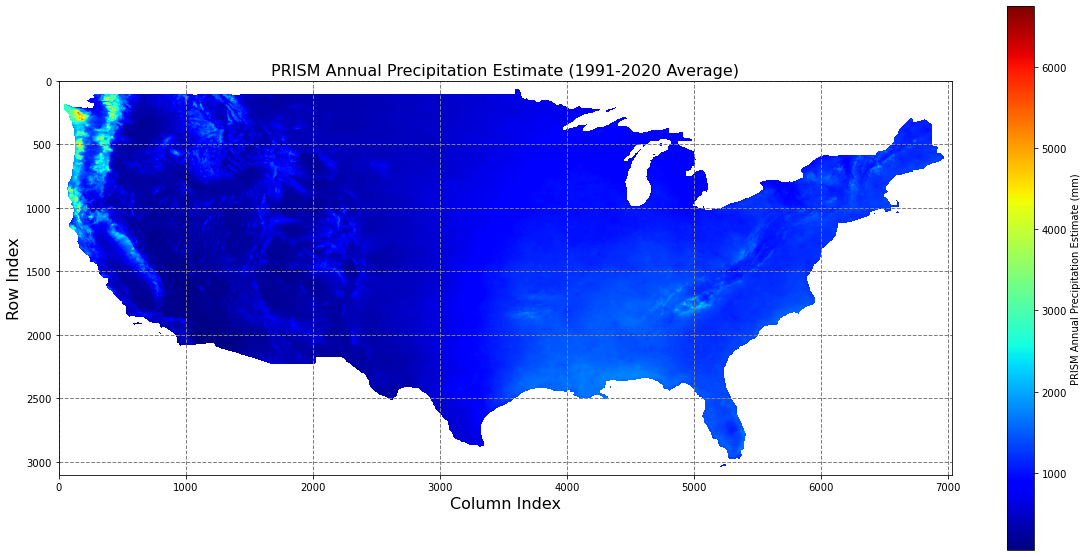

In [5]:
#----------------------------------------------------------------------------------------------------------------------
#Check/plot PRISM data using matplotlib
#https://pymorton.wordpress.com/2014/04/26/plotting-prism-arrays-using-matplotlib-imshow/

#Create figure and axes
fig, ax = plt.subplots(figsize=(20,10))

#Plot using the "imshow" command
#x-axis is longitude and stored as columns ((prism_data.shape[1])) 
#y-axis is latitude and stored as rows (prism_data.shape[0])
prism_plot = ax.imshow(prism_data, cmap='jet')

#Add axis labels
ax.set_xlabel('Column Index', fontsize=16)
ax.set_ylabel('Row Index', fontsize=16)
ax.set_title('PRISM Annual Precipitation Estimate (1991-2020 Average)', fontsize=16)

#Add quick color bar (units of this precipitation data are mm)
cbar = fig.colorbar(prism_plot)
cbar.set_label('PRISM Annual Precipitation Estimate (mm)')

#Add grid
ax.grid(color='grey', linestyle='--', linewidth=1)
#----------------------------------------------------------------------------------------------------------------------

In [6]:
#----------------------------------------------------------------------------------------------------------------------
#Locate gridpoint that is nearest to (-119.69203, 34.422874) for Santa Barbara & nearest to (-120.29199, 38.49312) for Sierra Nevada

#Note: From the above test plot of the PRISM data we see that the PRISM values are indexed in such a way that the first entry in the array is 
#the top left corner of the domain. This is an important consideration for when we create our lon/lat 1-D arrays below.

#Create lon and lat 1-D arrays for the PRISM data
lons = np.linspace(prism_xll, prism_xll + prism_cols * prism_cs, num=prism_cols)
lats = np.linspace(prism_yll + prism_rows * prism_cs, prism_yll, num=prism_rows)
#----------------------------------------------------------------------------------------------------------------------
#Locate index values that correspond to lon and lat coordinates for Santa Barbara & Sierra Nevada

#Define lon and lat values of Santa Barbara & Sierra Neveda gridpoints
sb_lon = -119.69203
sn_lon = -120.29199
sb_lat = 34.422874
sn_lat = 38.49312

#The np.abs().argmin() method of finding index of nearest neighbor value came from: https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
#Remember also that rows in prism data = lats & columns = lons
sb_prism_gridpoint = prism_data[np.abs(lats-sb_lat).argmin(),np.abs(lons-sb_lon).argmin()]
sn_prism_gridpoint = prism_data[np.abs(lats-sn_lat).argmin(),np.abs(lons-sn_lon).argmin()]
#----------------------------------------------------------------------------------------------------------------------
#Print PRISM values (mm)
print('The PRISM estimated annual precipitation for Santa Barbara is '+str(sb_prism_gridpoint)+'mm')
print('The PRISM estimated annual precipitation for the Sierra Neveda Range is '+str(sn_prism_gridpoint)+'mm')
#----------------------------------------------------------------------------------------------------------------------
#PRISM estimate (1991-2020 30-year normal) for Santa Barbara annual precipitation is ~496mm, while PRISM estimate for Sierra Nevada is ~1279.12mm
#This agrees somewhat well with a quick Google search for both areas. Nothing seems to be surprising at least.

The PRISM estimated annual precipitation for Santa Barbara is 496.32mm
The PRISM estimated annual precipitation for the Sierra Neveda Range is 1279.12mm


**Question 2: Compute the daily dQ and  KBDI for the WRF model gridpoints in Santa Barbara and Sierra Neveda using the English form of the dQ equation**

*The next 2 cells in this notebook perform the following tasks*:
- Read in WRF gridpoint data for Santa Barbara (-119.69203, 34.42287) and Sierra Nevada (-120.29199, 38.49312) and convert temperature and rainfall data to english units (°F and inches)

- Compute the daily dQ and KBDI values for both the Santa Barbara and Sierra Nevada WRF gridpoints

- Note that all computed KBDI values less than zero have been manually set to zero.
---------------------------------------------------------------------------------------------------------------------
- The equation used to caluclate the daily drought factor for each location is: $ dQ = \frac{(800-Q(t-1))(0.968e^{0.486T}-8.30)dt}{1+10.88e^{-0.0441R}} $

- Where: $ Q(t-1) $ = The KBDI value from the previous day (0-800) | $ T $ = Daily Maximum Temperature (°F) | $ d\tau $ = Time Increment (Days) | $ R $ = Mean Annual Precipitation (inches; Thanks PRISM!)

- The equation used to calculate the daily KBDI value for each location is: $ Q(t) = Q(t-1) - 100P(t) + dQ $

- Where: $ Q(t-1) $ = The daily KBDI value from the previous day (0-800) | $ P(t) $ = The Daily Accumulated Precipitation (inches) | $ dQ $ = The Drought Factor

In [7]:
#----------------------------------------------------------------------------------------------------------------------
#Question #2: Compute the daily drought factor & KBDI for the model gridpoints in Santa Barbara and Sierra Neveda using the English form of the drought factor equation
#----------------------------------------------------------------------------------------------------------------------
#Read in model data for both gridpoints
sb_model_gridpoint = pd.read_csv('/Users/mariandob/Desktop/Life/Academics/UCSB/Courses/Q07_Spring_2022/Geog_288CJ/Fire_Weather_Index_Project/Data/Santa_Barbara_Model_Gridpoint.csv')
sn_model_gridpoint = pd.read_csv('/Users/mariandob/Desktop/Life/Academics/UCSB/Courses/Q07_Spring_2022/Geog_288CJ/Fire_Weather_Index_Project/Data/Sierra_Nevada_Model_Gridpoint.csv')
#----------------------------------------------------------------------------------------------------------------------
#Convert model daily maximum temp from Kelvin to Fahrenheit
sb_model_temp_f_daily = (sb_model_gridpoint['T2_daily_max']-273.15)*(9/5)+32
sn_model_temp_f_daily = (sn_model_gridpoint['T2_daily_max']-273.15)*(9/5)+32

#Convert model daily precipitation accumulation from mm to inches
sb_model_precip_in_daily = sb_model_gridpoint['RAINNC_daily']/25.4
sn_model_precip_in_daily = sn_model_gridpoint['RAINNC_daily']/25.4
#----------------------------------------------------------------------------------------------------------------------

In [8]:
#----------------------------------------------------------------------------------------------------------------------
#Create empty list to store Drought Factor & KBDI values for each gridpoint
sb_model_df_daily = []
sn_model_df_daily = []

sb_model_kbdi_daily = []
sn_model_kbdi_daily = []
#----------------------------------------------------------------------------------------------------------------------
#Compute daily KBDI value for Santa Barbara gridpoint
for index, date in enumerate (sb_model_gridpoint['Time']):
    
    #If the date is 08-31, KBDI is set to 100 since this is the start of the SON season
    #We set the drought factor (df) to zero to ensure proper indexing is maintained
    if date[5::] == '08-31':
        sb_model_df_daily.append(0)
        sb_model_kbdi_daily.append(100)
    
    #If the daily maximum temperature is less than 50°F on a day, the drought factor is 0 and the KBDI calculation is the same
    elif sb_model_temp_f_daily[index] < 50:
        sb_model_df_daily.append(0)
        sb_model_kbdi_daily_single_value_placeholder = sb_model_kbdi_daily[index-1]-100*sb_model_precip_in_daily[index]+sb_model_df_daily[index]
        if sb_model_kbdi_daily_single_value_placeholder >= 0:
            sb_model_kbdi_daily.append(sb_model_kbdi_daily_single_value_placeholder)
        else:
            sb_model_kbdi_daily.append(0)
    
    #If the day does not meet one of the criteria above, calculate the drought factor and KBDI value for that day following normal english equations
    #Also, if the daily KBDI value is negative, set the daily value to zero
    else:
        sb_model_df_daily.append((800-sb_model_kbdi_daily[index-1])*(0.968*np.exp(0.0486*sb_model_temp_f_daily[index])-8.30)*(1/(1+10.88*np.exp(-0.0441*(sb_prism_gridpoint/25.4))))*0.001)
        sb_model_kbdi_daily_single_value_placeholder = sb_model_kbdi_daily[index-1]-100*sb_model_precip_in_daily[index]+sb_model_df_daily[index]
        if sb_model_kbdi_daily_single_value_placeholder >= 0:
            sb_model_kbdi_daily.append(sb_model_kbdi_daily_single_value_placeholder)
        else:
            sb_model_kbdi_daily.append(0)
#----------------------------------------------------------------------------------------------------------------------
#Compute daily KBDI value for Sierra Nevada gridpoint
for index, date in enumerate (sn_model_gridpoint['Time']):
    
    #If the date is 08-31, KBDI is set to 100 since this is the start of the SON season
    #We set the drought factor (df) to zero to ensure proper indexing is maintained
    if date[5::] == '08-31':
        sn_model_df_daily.append(0)
        sn_model_kbdi_daily.append(100)
    
    #If the daily maximum temperature is less than 50°F on a day, the drought factor is 0 and the KBDI calculation is the same
    #Also, if the daily KBDI value is negative, set the daily value to zero
    elif sn_model_temp_f_daily[index] < 50:
        sn_model_df_daily.append(0)
        sn_model_kbdi_daily_single_value_placeholder = sn_model_kbdi_daily[index-1]-100*sn_model_precip_in_daily[index]+sn_model_df_daily[index]
        if sn_model_kbdi_daily_single_value_placeholder >= 0:
            sn_model_kbdi_daily.append(sn_model_kbdi_daily_single_value_placeholder)
        else:
            sn_model_kbdi_daily.append(0)
            
    #If the day does not meet one of the criteria above, calculate the drought factor and KBDI value for that day following normal english equations   
    #Also, if the daily KBDI value is negative, set the daily value to zero
    else:
        sn_model_df_daily.append((800-sn_model_kbdi_daily[index-1])*(0.968*np.exp(0.0486*sn_model_temp_f_daily[index])-8.30)*(1/(1+10.88*np.exp(-0.0441*(sn_prism_gridpoint/25.4))))*0.001)
        sn_model_kbdi_daily_single_value_placeholder = sn_model_kbdi_daily[index-1]-100*sn_model_precip_in_daily[index]+sn_model_df_daily[index]
        if sn_model_kbdi_daily_single_value_placeholder >= 0:
            sn_model_kbdi_daily.append(sn_model_kbdi_daily_single_value_placeholder)
        else:
            sn_model_kbdi_daily.append(0)
#----------------------------------------------------------------------------------------------------------------------
#Add in new dataframe columns for the Santa Barbarba and Sierra Nevada gridpoint files which have the calculated KBDI values
#This will allow us to use datetime and grouping functions to calculate seasonal mean seasonal mean and other statisics from the daily KBDI values
#https://stackoverflow.com/questions/26666919/add-column-in-dataframe-from-list
sb_model_gridpoint['Daily_KBDI'] = sb_model_kbdi_daily
sn_model_gridpoint['Daily_KBDI'] = sn_model_kbdi_daily
#----------------------------------------------------------------------------------------------------------------------

**Question 3: Compute the daily Fosberg Fire Weather Index for the Santa Barbara and Sierra Nevada WRF Gridpoints**

*The cell below performs the following task:*

- Calculates the daily Fosberg Fire Weather Index (FFWI; with slight modifications) for the Santa Barbara and Sierra Nevada WRF Gridpoints.
---------------------------------------------------------------------------------------------------------------
- The equation for the FFWI is: $ FFWI = \frac{\sqrt{1+V^{2}}}{0.3022}(1-\frac{2a}{30}+\frac{1.5a^{2}}{30}-\frac{0.5a}{30}) $

- Where: $ V $ = Wind Speed (mph) | $ T $ = Air Temperature (°F) | $ RH $ = Relative Humidity (%) | $ a $ = Equilibrium Moisture Content =  $ \begin{cases} 0.03229+0.281073RH & if \ RH < 10 \\ 2.22749+0.160107RH-0.01478T & if \ 10 \le  RH < 50 \\ 21.0606+0.005565RH^{2}-0.00035TRH-0.483199RH & if \ RH \ge 50 \end{cases} $
---------------------------------------------------------------------------------------------------------------
- **Modification: For our calculations of the daily FFWI we use Daily Maximum Wind Speed, Daily Maximum Air Temperature, and Daily Minimum Relative Humidity from the WRF gridpoints.**

- **Note: The FFWI is a value that ranges from 0 to 100. Any computed values that were less than zero were manually set to zero.**

In [9]:
#----------------------------------------------------------------------------------------------------------------------
#Question #3: Compute the daily Fosberg Fire Weather Index (FFWI) for the model gridpoints in Santa Barbara and Sierra Neveda
#----------------------------------------------------------------------------------------------------------------------
#Create empty lists to store FFWI values for each gridpoint
sb_model_ffwi_daily = []
sn_model_ffwi_daily = []
#----------------------------------------------------------------------------------------------------------------------
#Compute daily FFWI value for Santa Barbara gridpoint
for index, date in enumerate (sb_model_gridpoint['Time']):
    
    #First determine the value of the "a" coefficient for the FFWI calculation
    #This value depends on the daily relative humidity (RH) value
    if sb_model_gridpoint['RH2_daily_min'][index] < 10:
        a = 0.03229+0.281073*sb_model_gridpoint['RH2_daily_min'][index]-0.000578*sb_model_gridpoint['T2_daily_max'][index]*sb_model_gridpoint['RH2_daily_min'][index]
    elif (sb_model_gridpoint['RH2_daily_min'][index] >= 10) & (sb_model_gridpoint['RH2_daily_min'][index] < 50):
        a = 2.2749+0.160107*sb_model_gridpoint['RH2_daily_min'][index]-0.01478*sb_model_gridpoint['T2_daily_max'][index]
    elif sb_model_gridpoint['RH2_daily_min'][index] >= 50:
        a = 21.0606+0.005565*((sb_model_gridpoint['RH2_daily_min'][index])**2)-0.00035*sb_model_gridpoint['T2_daily_max'][index]*sb_model_gridpoint['RH2_daily_min'][index]-0.483199*sb_model_gridpoint['RH2_daily_min'][index]
    
    #FFWI calculation
    #If FFWI is negative, set it to zero
    sb_model_ffwi_daily_single_value_placeholder = (((1+sb_model_gridpoint['WSP10_daily_max'][index]**2)**0.5)/0.3002)*(1-2*a*(1/30)+1.5*(a**2)*(1/30)-0.5*(a**3)*(1/30))
    if sb_model_ffwi_daily_single_value_placeholder >= 0:
        sb_model_ffwi_daily.append(sb_model_ffwi_daily_single_value_placeholder)
    else:
        sb_model_ffwi_daily.append(0)
#----------------------------------------------------------------------------------------------------------------------
#Compute daily FFWI value for Sierra Nevada gridpoint
for index, date in enumerate (sn_model_gridpoint['Time']):
    
    #First determine the value of the "a" coefficient for the FFWI calculation
    #This value depends on the daily relative humidity (RH) value
    if sn_model_gridpoint['RH2_daily_min'][index] < 10:
        a = 0.03229+0.281073*sn_model_gridpoint['RH2_daily_min'][index]-0.000578*sn_model_gridpoint['T2_daily_max'][index]*sn_model_gridpoint['RH2_daily_min'][index]
    elif (sn_model_gridpoint['RH2_daily_min'][index] >= 10) & (sn_model_gridpoint['RH2_daily_min'][index] < 50):
        a = 2.2749+0.160107*sn_model_gridpoint['RH2_daily_min'][index]-0.01478*sn_model_gridpoint['T2_daily_max'][index]
    elif sn_model_gridpoint['RH2_daily_min'][index] >= 50:
        a = 21.0606+0.005565*((sn_model_gridpoint['RH2_daily_min'][index])**2)-0.00035*sn_model_gridpoint['T2_daily_max'][index]*sn_model_gridpoint['RH2_daily_min'][index]-0.483199*sn_model_gridpoint['RH2_daily_min'][index]
    
    #FFWI calculation
    #If FFWI is negative, set it to zero
    sn_model_ffwi_daily_single_value_placeholder = (((1+sn_model_gridpoint['WSP10_daily_max'][index]**2)**0.5)/0.3002)*(1-2*a*(1/30)+1.5*(a**2)*(1/30)-0.5*(a**3)*(1/30))
    if sn_model_ffwi_daily_single_value_placeholder >= 0:
        sn_model_ffwi_daily.append(sn_model_ffwi_daily_single_value_placeholder)
    else:
        sn_model_ffwi_daily.append(0)
#----------------------------------------------------------------------------------------------------------------------
#Add in new dataframe columns for the Santa Barbarba and Sierra Nevada gridpoint files which have the calculated FFWI daily values
#This will allow us to use datetime and grouping functions to calculate seasonal mean and other statisics from the daily FFWI values
#https://stackoverflow.com/questions/26666919/add-column-in-dataframe-from-list
sb_model_gridpoint['Daily_FFWI'] = sb_model_ffwi_daily
sn_model_gridpoint['Daily_FFWI'] = sn_model_ffwi_daily
#----------------------------------------------------------------------------------------------------------------------

**Question 4: Compute the daily modified Fosberg Wire Weather Index (mFFWI) for the Santa Barbara and Sierra Nevada WRF Gridpoints**

*The cell below completes the following task:*

- Computes the daily Fuel Availability Factor (FAF) to then compute the  modified Fosberg Wire Weather Index (mFFWI) for the Santa Barbara and Sierra Nevada WRF Gridpoints.
---------------------------------------------------------------------------------------------------------------
- The equation for mFFWI is: $ mFFWI = FAF * FFWI $

- Where: $ FAF  = 0.000002(KBDI)^{2}+0.72 $



In [10]:
#----------------------------------------------------------------------------------------------------------------------
#Question #4: Compute the daily & seasonal modified Fosberg Fire Weather Index (mFFWI) for the model gridpoints in Santa Barbara and Sierra Neveda
#----------------------------------------------------------------------------------------------------------------------
#The mFFWI is simply the Fuel Availability Factor (FAF) multiplied by the FFWI

#First create a daily FAF column in our pandas dataframe for each location
#Daily FAF is dependent on daily KBDI
sb_model_gridpoint['Daily_FAF'] = 0.000002*(sb_model_gridpoint['Daily_KBDI']**2)+0.72
sn_model_gridpoint['Daily_FAF'] = 0.000002*(sn_model_gridpoint['Daily_KBDI']**2)+0.72

#Then simply take the daily FAF and multiply it by the daily FFWI and create a new column in our dataframe
sb_model_gridpoint['Daily_mFFWI'] = sb_model_gridpoint['Daily_FAF'] * sb_model_gridpoint['Daily_FFWI']
sn_model_gridpoint['Daily_mFFWI'] = sn_model_gridpoint['Daily_FAF'] * sn_model_gridpoint['Daily_FFWI']
#----------------------------------------------------------------------------------------------------------------------

**Question 5: Compute the daily Hot Dry Windy Index (HDWI) for the Santa Barbara and Sierra Nevada WRF Gridpoints**

*The cell below performs the following task:* 

- Computes the daily HDWI (with modifications) for the Santa Barbara and Sierra Nevada WRF Gridpoints
---------------------------------------------------------------------------------------------------------------
- The equation for the HDWI is: $ HDWI = U * VPD(T,q) $

- Where: $ U $ = Windspeed within a layer (e.g. 0-500m) | $ VPD(T,q) $ = Vapor Pressure Deficit within a layer (function of air temperature, $ T $, and absolute moisture content, $ q $) = $ e_{s}(T) - e(q) $ where $ e_{s}(T) $ and $ e(q) $ are the saturation and absolute water vapor pressures respectively.

- For simplicity, in the calculation of the HDWI we will not be using the daily wind and daily temperature fields from a layer. Instead we will use the daily maximum wind and temperature fields for all necessary calculations for both WRF gridpoints!
---------------------------------------------------------------------------------------------------------------
**Modifications: In order to compute the water vapor pressure deficit from the WRF gridpoints we must:**
- Compute the saturation water vapor pressure using the daily maximum temperature from both WRF gridpoints along with the following equation: $ e_{s} = 6.112e^{\frac{17.67T}{T+243.5}} $ where $ T $ is daily maximum temperature in °C!

- Use the water vapor pressure form of the relative humidity equation to back-solve for the daily absolute water vapor pressure [$ e(q) $]

- The water vapor pressure form of the relative humidity ($ RH $) equation is given by: $ RH(T,q) = e(q)/e_s(T) $

In [11]:
#----------------------------------------------------------------------------------------------------------------------
#Question 5: Compute the daily Hot Dry Windy Index (HDWI) for the Santa Barbara and Sierra Nevada WRF Gridpoints
#----------------------------------------------------------------------------------------------------------------------
#We will write a loop which runs through each day of data and computes the saturation vapor pressure, actual vapor pressure, vapor pressure deficit, and HDWI for both the Santa Barbara and Sierra Nevada gridpoints

#First we define our empty lists which will store each computed variable we are interested
#For this computation we will choose to save only the HDWI index values for each day and not any of the intermediate vapor pressure variables
sb_model_hdwi_daily = []
sn_model_hdwi_daily = []

#Convert model gridpoint daily maximum temperatures from Kelvin to Celcius
#This is to be used in the equation to calcuate the daily saturation vapor pressure
sb_model_temp_c_daily = sb_model_gridpoint['T2_daily_max'] - 273.15
sn_model_temp_c_daily = sn_model_gridpoint['T2_daily_max'] - 273.15
#----------------------------------------------------------------------------------------------------------------------
#For each date, do the following for the Santa Barbara WRF gridpoint
for index, date in enumerate (sb_model_gridpoint['Time']):
    
    #Calculate the daily saturation vapor pressure using daily maximum temperature. Using temperature units of °C results in the vapor pressure units being equal to hPa.
    sb_model_sat_vapor_pressure_daily = 6.112*np.exp((17.67*sb_model_temp_c_daily[index])/(sb_model_temp_c_daily[index]+243.5))

    #Next calculate the daily absolute vapor pressure using the model daily minimum relative humidity and the computed daily saturation vapor pressure
    sb_model_abs_vapor_pressure_daily = sb_model_gridpoint['RH2_daily_min'][index]/sb_model_sat_vapor_pressure_daily

    #Next calculate the daily vapor pressure deficit, which is simply the difference between the daily saturation vapor pressure and the daily absolute vapor pressure
    sb_model_vapor_pressure_deficit_daily = sb_model_sat_vapor_pressure_daily - sb_model_abs_vapor_pressure_daily

    #Now we have everything we need to calculate the daily HDWI!
    sb_model_hdwi_daily.append(sb_model_gridpoint['WSP10_daily_max'][index]*sb_model_vapor_pressure_deficit_daily)
#----------------------------------------------------------------------------------------------------------------------
#For each date, do the following for the Sierra Nevada WRF gridpoint
for index, date in enumerate (sn_model_gridpoint['Time']):
    
    #Calculate the daily saturation vapor pressure using daily maximum temperature. Using temperature units of °C results in the vapor pressure units being equal to hPa.
    sn_model_sat_vapor_pressure_daily = 6.112*np.exp((17.67*sn_model_temp_c_daily[index])/(sn_model_temp_c_daily[index]+243.5))

    #Next calculate the daily absolute vapor pressure using the model daily minimum relative humidity and the computed daily saturation vapor pressure
    sn_model_abs_vapor_pressure_daily = sn_model_gridpoint['RH2_daily_min'][index]/sn_model_sat_vapor_pressure_daily

    #Next calculate the daily vapor pressure deficit, which is simply the difference between the daily saturation vapor pressure and the daily absolute vapor pressure
    sn_model_vapor_pressure_deficit_daily = sn_model_sat_vapor_pressure_daily - sn_model_abs_vapor_pressure_daily

    #Now we have everything we need to calculate the daily HDWI!
    sn_model_hdwi_daily.append(sn_model_gridpoint['WSP10_daily_max'][index]*sn_model_vapor_pressure_deficit_daily)
#----------------------------------------------------------------------------------------------------------------------
#Add in new dataframe columns for the Santa Barbarba and Sierra Nevada gridpoint files which have the calculated daily HDWI values
#This will allow us to use datetime and grouping functions to calculate seasonal mean and other statisics from the daily HDWI values
#https://stackoverflow.com/questions/26666919/add-column-in-dataframe-from-list
sb_model_gridpoint['Daily_HDWI'] = sb_model_hdwi_daily
sn_model_gridpoint['Daily_HDWI'] = sn_model_hdwi_daily
#----------------------------------------------------------------------------------------------------------------------

**Question 6A: Plot the time series of daily KBDI for the Santa Barbara and Sierra Nevada WRF gridpoints**

*The following cell performs the following task:*

- Plots the daily KBDI values for the Santa Barbara and Sierra Nevada WRF gridpoints*

- Note: A second plot showing just the first 100 days of our daily computed KBDI data is shown as well.

**Discussion of Daily KBDI Results**
- The Sierra Nevada and Santa Barbara WRF gridpoints display similar behaviors in the oscillation of daily KBDI values over time. We see that the Sierra Nevada gridpoint features more days where the daily KBDI value is zero, which could be indicative of the fact that the Seirra Nevada region experiences more precipitation during the SON season than Santa Barbara does. This larger amount of precipitation could force the daily KBDI value for the Sierra Nevada gridpoint to go negative, which from our code results in a manual assignment of the negative value to be zero. From our PRISM analysis we know that the Sierra Neveda gridpoint experiences more precipitation when compared to the Santa Barbara gridpoint, which could further help to support this reasoning.

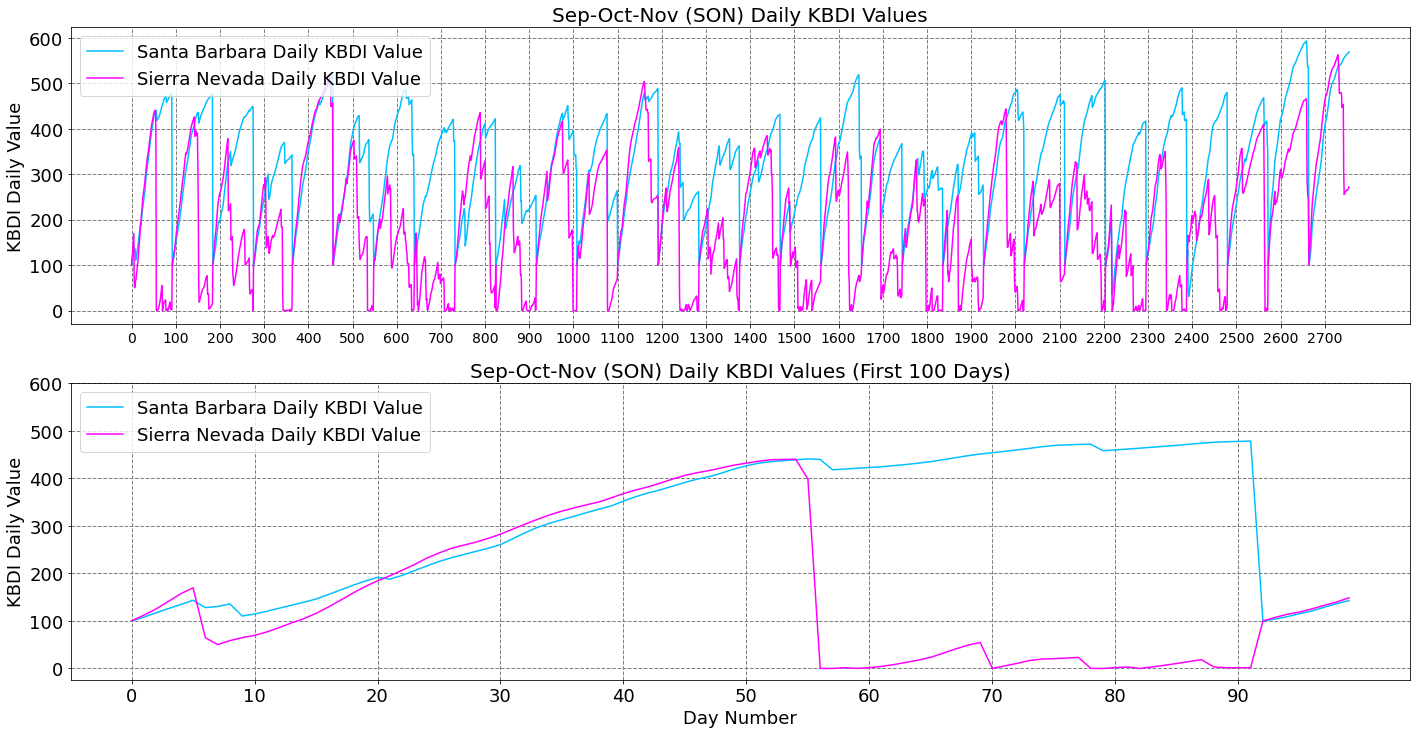

In [12]:
#Plot Santa Barbara and Sierra Nevada Daily KBDI values

#Create figure and axis for plotting
fig,(ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(24,12))

#Define x-axis variable, which is the amount of days in our dataset
sb_days = np.arange(0,np.size(sb_model_gridpoint['Time']),1)
sn_days = np.arange(0,np.size(sn_model_gridpoint['Time']),1)

#Add x-axis variable for first 100 days
sb_days_first_100 = np.arange(0,100,1)
sn_days_first_100 = np.arange(0,100,1)

#Plot daily KBDI (all days)
ax1.plot(sb_days,sb_model_kbdi_daily, color='deepskyblue', label='Santa Barbara Daily KBDI Value')
ax1.plot(sn_days,sn_model_kbdi_daily, color='magenta', label='Sierra Nevada Daily KBDI Value')

#Plot daily KBDI (first 100 days)
ax2.plot(sb_days_first_100,sb_model_kbdi_daily[0:100], color='deepskyblue', label='Santa Barbara Daily KBDI Value')
ax2.plot(sn_days_first_100,sn_model_kbdi_daily[0:100], color='magenta', label='Sierra Nevada Daily KBDI Value')

#Add legend
ax1.legend(loc='upper left', fontsize=18)
ax2.legend(loc='upper left', fontsize=18)

#Customize axes labels and styles
ax1.set_title('Sep-Oct-Nov (SON) Daily KBDI Values', fontsize=20)
ax2.set_title('Sep-Oct-Nov (SON) Daily KBDI Values (First 100 Days)', fontsize=20)

ax2.set_xlabel('Day Number', fontsize=18)

ax1.set_ylabel('KBDI Daily Value', fontsize=18)
ax2.set_ylabel('KBDI Daily Value', fontsize=18)

ax1.set_xticks(sb_days[::100])
ax2.set_xticks(sb_days_first_100[::10])

ax1.set_yticks(np.arange(0,700,100))
ax2.set_yticks(np.arange(0,700,100))

ax1.set_xticklabels(sb_days[::100], fontsize=14)
ax2.set_xticklabels(sb_days_first_100[::10], fontsize=18)

ax1.set_yticklabels(np.arange(0,700,100), fontsize=18)
ax2.set_yticklabels(np.arange(0,700,100), fontsize=18)

#ax1.tick_params(axis='both', which='major', labelsize=16)
#ax2.tick_params(axis='both', which='major', labelsize=16)

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)

#Show plot
plt.show()

**Question 6B: Compute and plot the seasonal  KBDI mean, standard deviation, minimum, and maximum values for both WRF gridpoints**

*The 2 cells below perform the following tasks:*
- Calculates the seasonal mean, standard deviation, minimum, and maximum KBDI values for the Santa Barbara and Sierra Nevada gridpoints.

- Plots these statistics as a multipanel plot

**Discussion of Seasonal KBDI Statistics**
- In general, the Santa Barbara WRF gridpoint appears to dsiplay less seasonal KBDI variability, particularly with respect to the seasonal mean, seasonal maximum, and seasonal minimum values. On the contrary, the Sierra Nevada gridpoint displays larger seasonal KBDI variability when considering the same statistical quantities. As an educated guess, I would wager that this is primarily due to greater interannual variability in daily precipitaiton within the Sierra Nevada mountain range, which can force large flucations in daily, and thus seasonal mean, KBDI values. I would assume that in Santa Barbara the interannual precipitation variability is much less, which would result in less pertubed seasonal KBDI statistical values. Also, it is shown that in many cases KBDI values are typically larger in Santa Barbara which could be related to the snigciantly smaller daily precipitation contribution in this location when compared to the Sierra Nevada WRF gridpoint.

In [13]:
#----------------------------------------------------------------------------------------------------------------------
#Group dataframe by year and calculate mean of all dataframe columns. Then just grab the KBDI column values.
#https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column/47140458#47140458
sb_model_kbdi_yearly_mean = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('mean')['Daily_KBDI'].values
sn_model_kbdi_yearly_mean = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('mean')['Daily_KBDI'].values

#Group dataframe by year and calculate maximum value of all dataframe columns. Then just grab the KBDI column values.
#https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column/47140458#47140458
sb_model_kbdi_yearly_max = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('max')['Daily_KBDI'].values
sn_model_kbdi_yearly_max = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('max')['Daily_KBDI'].values

#Group dataframe by year and calculate minimum value of all dataframe columns. Then just grab the KBDI column values.
#https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column/47140458#47140458
sb_model_kbdi_yearly_min = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('min')['Daily_KBDI'].values
sn_model_kbdi_yearly_min = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('min')['Daily_KBDI'].values

#Group dataframe by year and calculate standard deviation value of all dataframe columns. Then just grab the KBDI column values.
#https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column/47140458#47140458
sb_model_kbdi_yearly_std = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('std')['Daily_KBDI'].values
sn_model_kbdi_yearly_std = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('std')['Daily_KBDI'].values
#----------------------------------------------------------------------------------------------------------------------

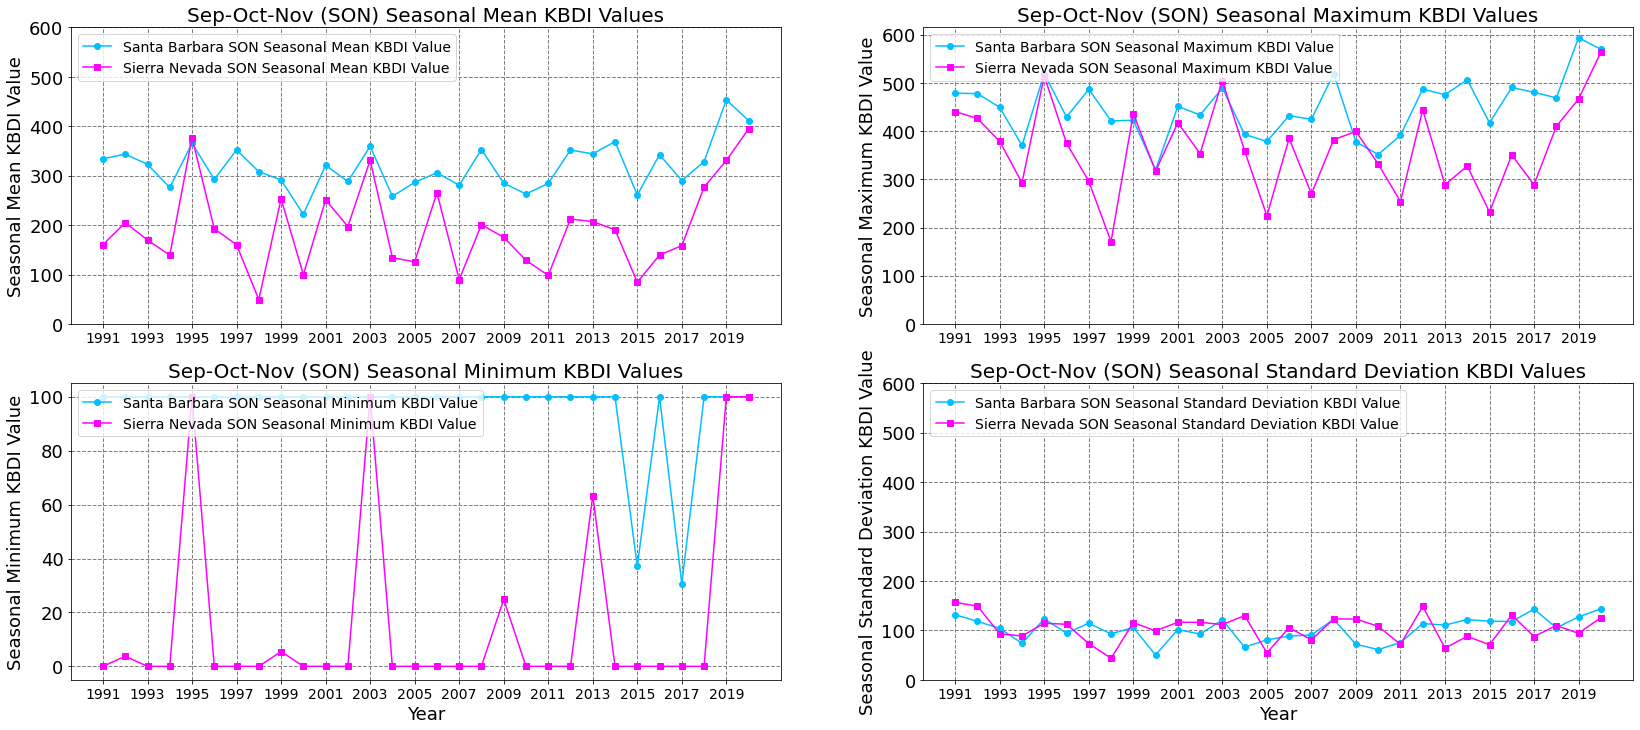

In [14]:
#----------------------------------------------------------------------------------------------------------------------
#Plot yearly SON KBDI statistics for Santa Barbarba and Sierra Nevada

#Create figure and axis for plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(28,12))

#Define x-axis variable
years = np.arange(1991,2021,1)
#----------------------------------------------------------------------------------------------------------------------
#Plot yearly KBDI mean
ax1.plot(years,sb_model_kbdi_yearly_mean, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Mean KBDI Value')
ax1.plot(years,sn_model_kbdi_yearly_mean, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Mean KBDI Value')

#Plot yearly KBDI maximum values
ax2.plot(years,sb_model_kbdi_yearly_max, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Maximum KBDI Value')
ax2.plot(years,sn_model_kbdi_yearly_max, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Maximum KBDI Value')

#Plot yearly KBDI minimum values
ax3.plot(years,sb_model_kbdi_yearly_min, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Minimum KBDI Value')
ax3.plot(years,sn_model_kbdi_yearly_min, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Minimum KBDI Value')

#Plot yearly KBDI standard deviation values
ax4.plot(years,sb_model_kbdi_yearly_std, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Standard Deviation KBDI Value')
ax4.plot(years,sn_model_kbdi_yearly_std, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Standard Deviation KBDI Value')
#----------------------------------------------------------------------------------------------------------------------
#Add legend
ax1.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper left', fontsize=14)
ax3.legend(loc='upper left', fontsize=14)
ax4.legend(loc='upper left', fontsize=14)

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)
ax3.grid(color='grey', linestyle='--', linewidth=1)
ax4.grid(color='grey', linestyle='--', linewidth=1)

#Customize axes labels and styles
ax1.set_title('Sep-Oct-Nov (SON) Seasonal Mean KBDI Values', fontsize=20)
ax2.set_title('Sep-Oct-Nov (SON) Seasonal Maximum KBDI Values', fontsize=20)
ax3.set_title('Sep-Oct-Nov (SON) Seasonal Minimum KBDI Values', fontsize=20)
ax4.set_title('Sep-Oct-Nov (SON) Seasonal Standard Deviation KBDI Values', fontsize=20)

ax3.set_xlabel('Year', fontsize=18)
ax4.set_xlabel('Year', fontsize=18)

ax1.set_ylabel('Seasonal Mean KBDI Value', fontsize=18)
ax2.set_ylabel('Seasonal Maximum KBDI Value', fontsize=18)
ax3.set_ylabel('Seasonal Minimum KBDI Value', fontsize=18)
ax4.set_ylabel('Seasonal Standard Deviation KBDI Value', fontsize=18)

ax1.set_xticks(years[::2])
ax2.set_xticks(years[::2])
ax3.set_xticks(years[::2])
ax4.set_xticks(years[::2])

ax1.set_yticks(np.arange(0,700,100))
ax2.set_yticks(np.arange(0,700,100))
ax3.set_yticks(np.arange(0,120,20))
ax4.set_yticks(np.arange(0,700,100))

ax1.set_xticklabels(years[::2], fontsize=14)
ax2.set_xticklabels(years[::2], fontsize=14)
ax3.set_xticklabels(years[::2], fontsize=14)
ax4.set_xticklabels(years[::2], fontsize=14)

ax1.set_yticklabels(np.arange(0,700,100), fontsize=18)
ax2.set_yticklabels(np.arange(0,700,100), fontsize=18)
ax3.set_yticklabels(np.arange(0,120,20), fontsize=18)
ax4.set_yticklabels(np.arange(0,700,100), fontsize=18)

#Show plot
plt.show()
#----------------------------------------------------------------------------------------------------------------------

**Question 6C: Design criteria to identify weak, moderate, and extreme dry days using the computed KBDI values**

*The following cell performs the following task:*

- Creates a single box and whisker plot for the two WRF gridpoints which displays the quartile/percentile breakdowns for weak, moderate, and extreme dry days using only the daily KBDI values for each WRF gridpoint.
---------------------------------------------------------------------------------------------------------------
- The percentile breakdowns are as follows: 

- Weak = Less than the 25th percentile (i.e. the bottom whisker of the box plot) | Moderate = Between the 25th and 75th percentile (i.e. the box of the boxplot) | Extreme = Above the 75th percentile (i.e. the top whisker of the box plot)

- Note: These percentile breakdowns were user selected and are not based on any previous theory or literature. They simply serve as one simple method to try to characterize various levels of dry days only using daily KBDI values.
---------------------------------------------------------------------------------------------------------------
**Discussion of Box and Whisker Plot Results**
- Santa Barbara WRF gridpoint results: Weak dry days feature daily KBDI values that fall between ~25 to 250, moderately dry days contain daily KBDI values that fall between ~250-400, and extremely dry days see daily KBDI values that fall between 400-600.

- Sierra Nevada WRF gridpoint results: Weak dry days feature daily KBDI values that fall between ~0 to 100, moderately dry days contain daily KBDI values that fall between ~100-300, and extremely dry days see daily KBDI values that fall between 300-550.

- Additional Comments: From our box and whisker plot we see that for the Santa Barbara WRF gridpoint daily KBDI values over the SON seasons of 1991-2020 are distributed somewhat evenly among the 0 to 600 value spectrum, while for the Sierra Nevada gridpoint we see more of a clustering of the daily KBDI distribution around values of ~200 or less. Based on our defined criteria to identify weak, moderate, and extreme dry days, it appears that the range for extreme dry days (> 75th percentile of daily KBDI values) is larger for the Sierra Nevada than for Santa Barbara, while the range for weak dry days is smaller for the Sierra Nevada when compared to Santa Barbara. I interpret this as meaning that the Santa Barbara WRF gridpoint experiences a more even distribution of daily KBDI values between 0 and 600, while the Sierra Nevada gridpoint tends to experience daily KBDI values less than 300 most often. 

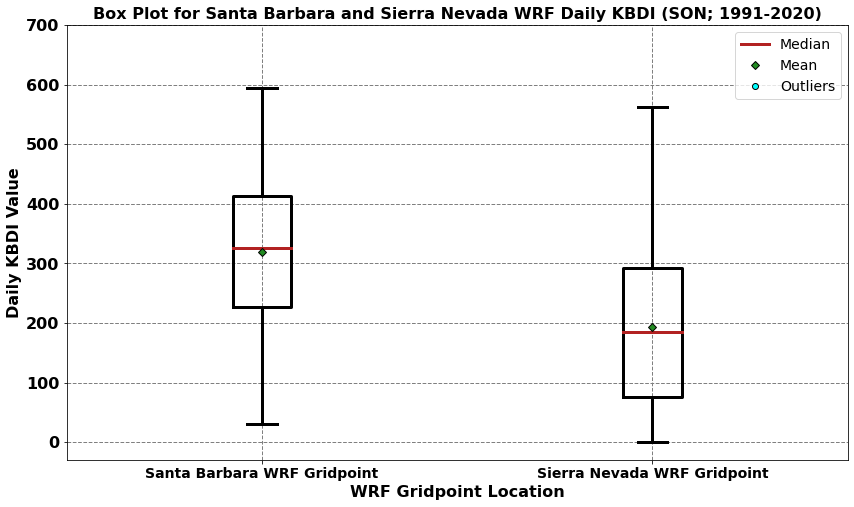

In [16]:
#----------------------------------------------------------------------------------------------------------------------
#Create figure and axis for plotting box and whisker plot
fig, ax = plt.subplots(figsize=(14,8))

#Set some cool style to our box plot
#Pretty much all of these styles were taken from: https://matplotlib.org/3.1.0/gallery/statistics/boxplot.html
boxprops     = dict(linestyle='-', linewidth=3, color='black')
whiskerprops = dict(linestyle='-', linewidth=3, color='black')
capprops     = dict(linestyle='-', linewidth=3, color='black')
medianprops  = dict(linestyle='-', linewidth=3, color='firebrick')
meanprops    = dict(marker='D', markerfacecolor='forestgreen', markeredgecolor='black', markersize=6)
flierprops   = dict(marker='o', markerfacecolor='cyan', markeredgecolor='black', markersize=6)

#Make box plot and label all axes
boxplot_sb_and_sn = ax.boxplot([sb_model_gridpoint['Daily_KBDI'], sn_model_gridpoint['Daily_KBDI']], showmeans=True, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, meanprops=meanprops, flierprops=flierprops)

#Add grid
ax.grid(color='grey', linestyle='--', linewidth=1)

#Customize x and y axes
ax.set_xticklabels(labels=['Santa Barbara WRF Gridpoint', 'Sierra Nevada WRF Gridpoint'], fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.set_xlabel('WRF Gridpoint Location', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_yticks(np.arange(0,800,100))
ax.set_yticklabels(np.arange(0,800,100), fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_ylabel('Daily KBDI Value', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_title('Box Plot for Santa Barbara and Sierra Nevada WRF Daily KBDI (SON; 1991-2020)', fontdict={'fontsize': 16, 'fontweight': 'bold'})

#Add legend to distinguish pieces of our boxplot
#This line came directly from: https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
ax.legend([boxplot_sb_and_sn['medians'][0], boxplot_sb_and_sn['means'][0], boxplot_sb_and_sn['fliers'][0]],['Median','Mean', 'Outliers'], fontsize=14)

#Show plot
plt.show()
#----------------------------------------------------------------------------------------------------------------------

**Question 6D: Calculate the linear trends for the seasonal mean KBDI values for both the Santa Barbara and Sierra Nevada WRF gridpoints**

*The following cell performs the following tasks:*

- Uses the "polyfit" function found in the numpy package to perform a first-order linear regression (using the least squared methodology) on the seasonal KBDI data for the Santa Barbara and Sierra Nevada WRF gridpoints. For the "polyfit" portion, we will mention that the x-variable will be the number of years starting from 0 and incrementing by 1 until 2020, and will not be the actual "year" value (e.g. 1991).

- Test our seasonal KBDI timeseries data to determine if there are any statistically signifcant trends using the Mann-Kendall significance test (from the pymannkendall package).

**Discussion on Linear Trends in Seasonal Mean KBDI Values**

- Using the "polyfit" function from the numpy package we show that the Santa Barbara and Sierra Nevada WRF gridpoints demonstrate a potential positive linear trend with similar slope values, indicating that over time seasonal mean KBDI values have increased. Using the Original Mann-Kendall test ("mk.original_test") function from the pymannkendall package, we find that the Santa Barbara seasonal mean KBDI values or the Sierra Nevada seasonal mean KBDI values do NOT exhibit any statistically significant trends at the 0.05 significance level.

Mann_Kendall_Test(trend='no trend', h=False, p=0.6427431760684212, z=0.46386680609104103, Tau=0.06206896551724138, s=27.0, var_s=3141.6666666666665, slope=0.5850783666121089, intercept=306.16869131530126)
Mann_Kendall_Test(trend='no trend', h=False, p=0.617392769071009, z=0.49954886809804416, Tau=0.06666666666666667, s=29.0, var_s=3141.6666666666665, slope=0.953073750133593, intercept=169.2107676672677)


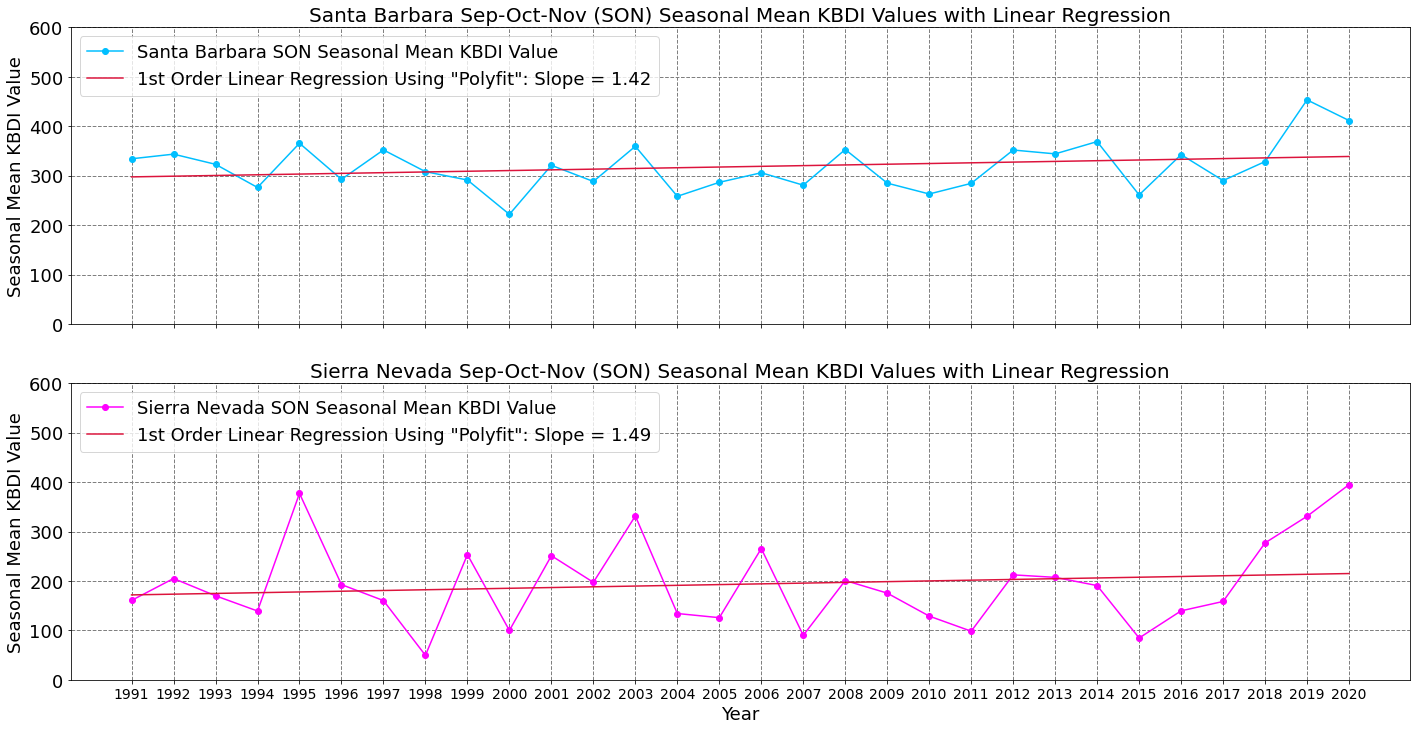

In [17]:
#----------------------------------------------------------------------------------------------------------------------
#Define x-variable to be used in the polyfit function
#We are workin with 30 years of seasonal KBDI values, so the x-axis will run from 0 to 29
x_variable_for_polyfit = np.arange(0, 30, 1)
#----------------------------------------------------------------------------------------------------------------------
#Define polyfit function for first order approximation
sb_linear_regression_kbdi_yearly = np.polyfit(x_variable_for_polyfit, sb_model_kbdi_yearly_mean, 1)
sn_linear_regression_kbdi_yearly = np.polyfit(x_variable_for_polyfit, sn_model_kbdi_yearly_mean, 1)

#Define polynomial using polyfit results
sb_first_order_polynomial_kbdi_yearly = np.poly1d(sb_linear_regression_kbdi_yearly)
sn_first_order_polynomial_kbdi_yearly = np.poly1d(sn_linear_regression_kbdi_yearly)
#----------------------------------------------------------------------------------------------------------------------
#Now we will use the pymankendall package to estimate the significance of the trend we found by passing the seasonal mean KBDI values
sb_model_mann_kendall_kbdi_yearly_mean = mk.original_test(sb_model_kbdi_yearly_mean)
sn_model_mann_kendall_kbdi_yearly_mean = mk.original_test(sn_model_kbdi_yearly_mean)

#If the user wants, they may print out the output of the Mann-Kendall trend test using the lines below:
print(sb_model_mann_kendall_kbdi_yearly_mean)
print(sn_model_mann_kendall_kbdi_yearly_mean)

#It appears that both trends are not statistically significant at the 0.05 significance level (default level for "mk.original_test" function)
#----------------------------------------------------------------------------------------------------------------------
#Now plot the seasonal mean KBDI gridpoint data, as well as the linear regression line

#Create a figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(24,12))

#Define x-axis variable
years = np.arange(1991,2021,1)
#----------------------------------------------------------------------------------------------------------------------
#Plot seasonal mean KBDI data for Santa Barbara, as well as the first order polynomial function we got from the 'polyfit' numpy function
ax1.plot(x_variable_for_polyfit, sb_model_kbdi_yearly_mean, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Mean KBDI Value')
ax1.plot(x_variable_for_polyfit, sb_first_order_polynomial_kbdi_yearly(x_variable_for_polyfit), color='crimson', label='1st Order Linear Regression Using "Polyfit": Slope = 1.42')

#Plot seasonal mean KBDI data for Sierra Nevada, as well as the first order polynomial function we got from the 'polyfit' numpy function
ax2.plot(x_variable_for_polyfit, sn_model_kbdi_yearly_mean, marker='o', color='magenta', label='Sierra Nevada SON Seasonal Mean KBDI Value')
ax2.plot(x_variable_for_polyfit, sn_first_order_polynomial_kbdi_yearly(x_variable_for_polyfit), color='crimson', label='1st Order Linear Regression Using "Polyfit": Slope = 1.49')
#----------------------------------------------------------------------------------------------------------------------
#Add legend
ax1.legend(loc='upper left', fontsize=18)
ax2.legend(loc='upper left', fontsize=18)

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)

#Customize axes labels and styles
ax1.set_title('Santa Barbara Sep-Oct-Nov (SON) Seasonal Mean KBDI Values with Linear Regression', fontsize=20)
ax2.set_title('Sierra Nevada Sep-Oct-Nov (SON) Seasonal Mean KBDI Values with Linear Regression', fontsize=20)

ax2.set_xlabel('Year', fontsize=18)

ax1.set_ylabel('Seasonal Mean KBDI Value', fontsize=18)
ax2.set_ylabel('Seasonal Mean KBDI Value', fontsize=18)

ax1.set_xticks(x_variable_for_polyfit)
ax2.set_xticks(x_variable_for_polyfit)

ax1.set_xticklabels([], fontsize=14)
ax2.set_xticklabels(years, fontsize=14)

ax1.set_yticks(np.arange(0,700,100))
ax2.set_yticks(np.arange(0,700,100))

ax1.set_yticklabels(np.arange(0,700,100), fontsize=18)
ax2.set_yticklabels(np.arange(0,700,100), fontsize=18)

#Show Plot
plt.show()
#----------------------------------------------------------------------------------------------------------------------

**Question 7A: Plot the timeseries of the daily FFWI, mFFWI, and HDWI for both the Santa Barbara and Sierra Nevada WRF gridpoints**

*The following cell performs the following task:*

- Creates a multipanel plot for daily FFWI, mFFWI, and HDWI for the Santa Barbara and Sierra Nevada WRF gridpoints

**Discussion on Daily FFWI, mFFWI, and HDWI:**

- Although the timeseries of daily FFWI and mFFWi are a bit difficult to interpret, it appears that both values are similar between the Santa Barbara and Sierra Nevada WRF gridpoints. Daily HDWI values appear to generally be larger in Santa Barbara when compared to the Sierra Nevada, but this signal is also not very clear.

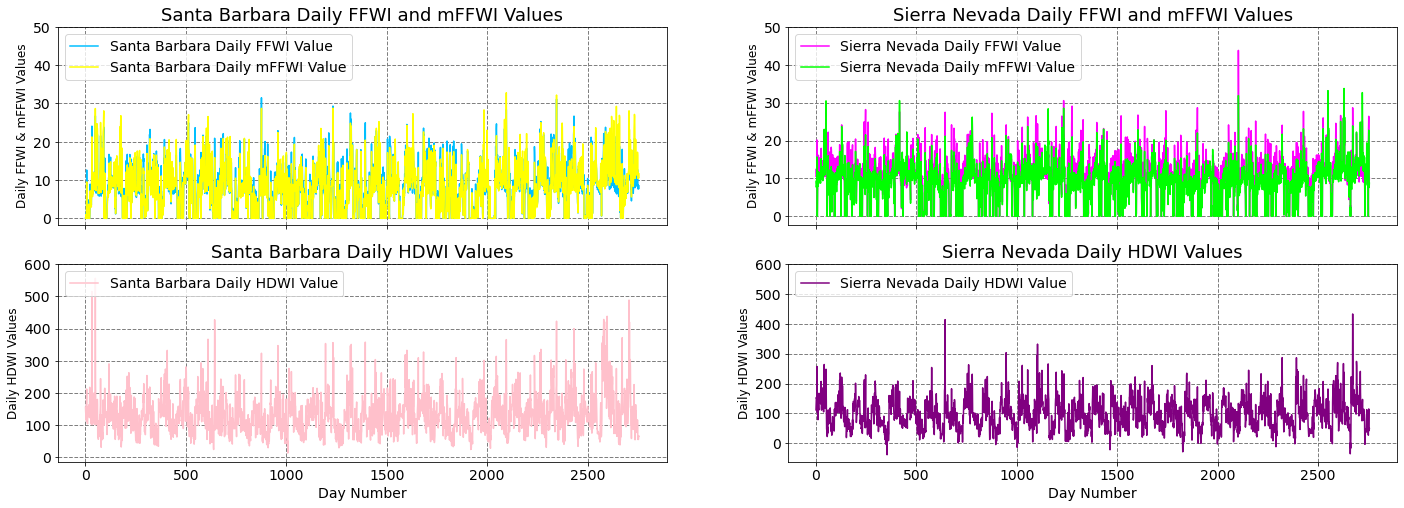

In [18]:
#----------------------------------------------------------------------------------------------------------------------
#Plot Santa Barbara and Sierra Nevada Daily FFWI, mFFWI, and HDWI values in a single panel plot

#Create figure and axis for plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(24,8))

#Define x-axis variable
days = np.arange(0,2756,1)
#----------------------------------------------------------------------------------------------------------------------
#Plot
ax1.plot(days,sb_model_ffwi_daily, color='deepskyblue', label='Santa Barbara Daily FFWI Value')
ax1.plot(days,sb_model_gridpoint['Daily_mFFWI'], color='yellow', label='Santa Barbara Daily mFFWI Value')

ax2.plot(days,sn_model_ffwi_daily, color='magenta', label='Sierra Nevada Daily FFWI Value')
ax2.plot(days,sn_model_gridpoint['Daily_mFFWI'], color='lime', label='Sierra Nevada Daily mFFWI Value')

ax3.plot(days,sb_model_hdwi_daily, color='pink', label='Santa Barbara Daily HDWI Value')

ax4.plot(days,sn_model_hdwi_daily, color='purple', label='Sierra Nevada Daily HDWI Value')
#----------------------------------------------------------------------------------------------------------------------
#Add legend
ax1.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper left', fontsize=14)
ax3.legend(loc='upper left', fontsize=14)
ax4.legend(loc='upper left', fontsize=14)

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)
ax3.grid(color='grey', linestyle='--', linewidth=1)
ax4.grid(color='grey', linestyle='--', linewidth=1)

#Customize axes labels and styles
ax1.set_title('Santa Barbara Daily FFWI and mFFWI Values', fontsize=18)
ax2.set_title('Sierra Nevada Daily FFWI and mFFWI Values', fontsize=18)
ax3.set_title('Santa Barbara Daily HDWI Values', fontsize=18)
ax4.set_title('Sierra Nevada Daily HDWI Values', fontsize=18)

ax3.set_xlabel('Day Number', fontsize=14)
ax4.set_xlabel('Day Number', fontsize=14)

ax1.set_ylabel('Daily FFWI & mFFWI Values', fontsize=12)
ax2.set_ylabel('Daily FFWI & mFFWI Values', fontsize=12)
ax3.set_ylabel('Daily HDWI Values', fontsize=12)
ax4.set_ylabel('Daily HDWI Values', fontsize=12)

ax1.set_xticks(days[::500])
ax2.set_xticks(days[::500])
ax3.set_xticks(days[::500])
ax4.set_xticks(days[::500])

ax1.set_yticks(np.arange(0,60,10))
ax2.set_yticks(np.arange(0,60,10))
ax3.set_yticks(np.arange(0,700,100))
ax4.set_yticks(np.arange(0,700,100))

ax1.set_xticklabels([], fontsize=14)
ax2.set_xticklabels([], fontsize=14)
ax3.set_xticklabels(days[::500], fontsize=14)
ax4.set_xticklabels(days[::500], fontsize=14)

ax1.set_yticklabels(np.arange(0,60,10), fontsize=14)
ax2.set_yticklabels(np.arange(0,60,10), fontsize=14)
ax3.set_yticklabels(np.arange(0,700,100), fontsize=14)
ax4.set_yticklabels(np.arange(0,700,100), fontsize=14)

plt.show()
#----------------------------------------------------------------------------------------------------------------------

**Question 7B: Calculate and plot the seasonal mean, seasonal minimum value, seasonal maximum value, and seasonal standard deviation for FFWI, mFFWI, and HDWI for the Santa Barbara and Sierra Nevada WRF gridpoints**

*The following 4 cells perform the following tasks:*

- Calculates the seasonal mean, seasonal minimum value, seasonal maximum value, and seasonal standard deviation for FFWI, mFFWI, and HDWI for the Santa Barbara and Sierra Nevada WRF gridpoints.

- Plots each of these statistical parameters in 3 seperate sets of panel plots.

**Discussion of Seasonal FFWI, mFFWI, and HDWI Statistics**
- **Seasonal FFWI Statistics:** The Sierra Nevada WRF gridpoint displays larger seasonal mean values of FFWI when compared to the Santa Barbara WRF gridpoint. Interannual seaonsal mean FFWI variability seems similar between the two gridpoints (from visual insepction). Another interesting point is although both WRF gridpoints seem to have similar maximum seasonal FFWI values, the Sierra Nevada gridpoint has slightly larger values. Perhaps the Sierra Nevada gridpoint experiences larger magnitudes of maximum daily wind speed, which would affect daily FFWI values.

- **Seasonal mFFWI Statistics:** The main observation is that the mFFWI seems to "tame" or reduce the magnitude of the seasonal FFWI values for both WRF gridpoints. Behavior of each calculated statistic (e.g. shape and variability) seems to be maintained between the FFWI and mFFWI plots. This makes sense, since the mFFWI simply includes the addition of a Fuel Availability Factor in the FFWI computation, which serves to slightly reduce the FFWI.

- **Seasonal HDWI Statistics:** The Santa Barbara WRF gridpoint features larger seasonal mean HDWI values, indicating that either the daily vapor pressure deficit or daily maximum wind speed, or both, are lager than the values found for the Sierra Nevada gridpoint. In accordance with this, the Santa Barbara gridpoint, in most years, sees the larger seasonal maximum and minimum HDWI values. This could indicate that Santa Barbara experiences days with a greater magnitude of wind speed or water vapor pressure deficit, or both, when compared to the Sierra Nevada region.

In [19]:
#----------------------------------------------------------------------------------------------------------------------
#Question #7B: Calculate and plot the seasonal mean, seasonal minimum value, seasonal maximum value, and seasonal standard deviation for FFWI, mFFWI, and HDWI for the Santa Barbara and Sierra Nevada gridpoints
#----------------------------------------------------------------------------------------------------------------------
#Group dataframe by year and calculate mean of all dataframe columns. Then just grab the daily FFWI column values.
#https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column/47140458#47140458
sb_model_ffwi_yearly_mean = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('mean')['Daily_FFWI'].values
sn_model_ffwi_yearly_mean = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('mean')['Daily_FFWI'].values
sb_model_ffwi_yearly_max  = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('max')['Daily_FFWI'].values
sn_model_ffwi_yearly_max  = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('max')['Daily_FFWI'].values
sb_model_ffwi_yearly_min  = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('min')['Daily_FFWI'].values
sn_model_ffwi_yearly_min  = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('min')['Daily_FFWI'].values
sb_model_ffwi_yearly_std  = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('std')['Daily_FFWI'].values
sn_model_ffwi_yearly_std  = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('std')['Daily_FFWI'].values

#Group dataframe by year and calculate mean of all dataframe columns. Then just grab the daily mFFWI column values.
#https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column/47140458#47140458
sb_model_mffwi_yearly_mean = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('mean')['Daily_mFFWI'].values
sn_model_mffwi_yearly_mean = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('mean')['Daily_mFFWI'].values
sb_model_mffwi_yearly_max  = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('max')['Daily_mFFWI'].values
sn_model_mffwi_yearly_max  = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('max')['Daily_mFFWI'].values
sb_model_mffwi_yearly_min  = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('min')['Daily_mFFWI'].values
sn_model_mffwi_yearly_min  = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('min')['Daily_mFFWI'].values
sb_model_mffwi_yearly_std  = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('std')['Daily_mFFWI'].values
sn_model_mffwi_yearly_std  = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('std')['Daily_mFFWI'].values

#Group dataframe by year and calculate mean of all dataframe columns. Then just grab the daily mFFWI column values.
#https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column/47140458#47140458
sb_model_hdwi_yearly_mean = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('mean')['Daily_HDWI'].values
sn_model_hdwi_yearly_mean = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('mean')['Daily_HDWI'].values
sb_model_hdwi_yearly_max  = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('max')['Daily_HDWI'].values
sn_model_hdwi_yearly_max  = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('max')['Daily_HDWI'].values
sb_model_hdwi_yearly_min  = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('min')['Daily_HDWI'].values
sn_model_hdwi_yearly_min  = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('min')['Daily_HDWI'].values
sb_model_hdwi_yearly_std  = sb_model_gridpoint.groupby(pd.to_datetime(sb_model_gridpoint['Time']).dt.year).agg('std')['Daily_HDWI'].values
sn_model_hdwi_yearly_std  = sn_model_gridpoint.groupby(pd.to_datetime(sn_model_gridpoint['Time']).dt.year).agg('std')['Daily_HDWI'].values
#----------------------------------------------------------------------------------------------------------------------

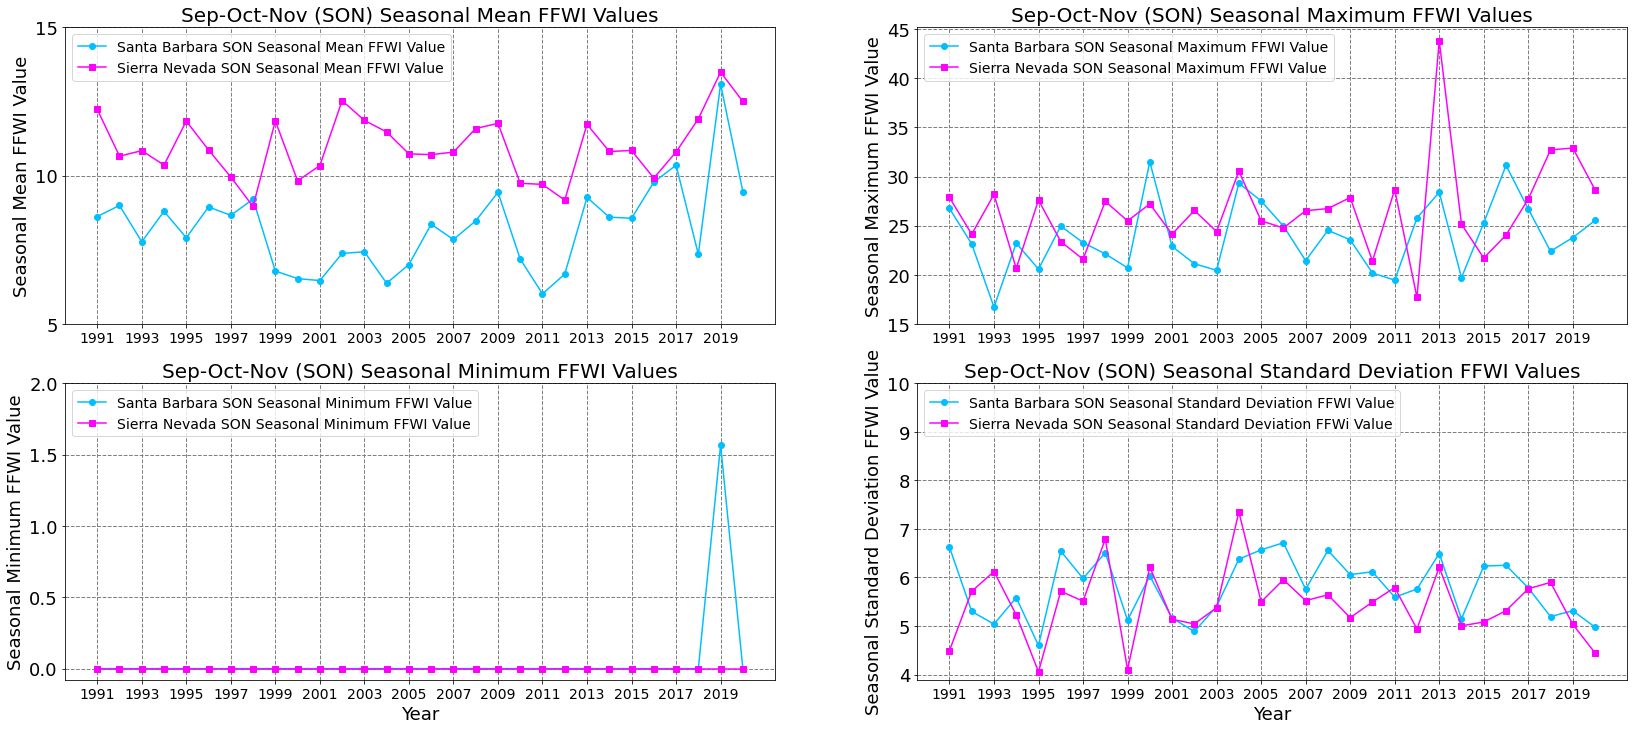

In [20]:
#----------------------------------------------------------------------------------------------------------------------
#Plot Seasonal SON FFWI statistics for Santa Barbarba and Sierra Nevada WRF gridpoints

#Create figure and axis for plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(28,12))

#Define x-axis variable
years = np.arange(1991,2021,1)
#----------------------------------------------------------------------------------------------------------------------
#Plot yearly FFWI mean
ax1.plot(years,sb_model_ffwi_yearly_mean, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Mean FFWI Value')
ax1.plot(years,sn_model_ffwi_yearly_mean, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Mean FFWI Value')

#Plot yearly FFWI maximum values
ax2.plot(years,sb_model_ffwi_yearly_max, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Maximum FFWI Value')
ax2.plot(years,sn_model_ffwi_yearly_max, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Maximum FFWI Value')

#Plot yearly FFWI minimum values
ax3.plot(years,sb_model_ffwi_yearly_min, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Minimum FFWI Value')
ax3.plot(years,sn_model_ffwi_yearly_min, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Minimum FFWI Value')

#Plot yearly FFWI standard deviation values
ax4.plot(years,sb_model_ffwi_yearly_std, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Standard Deviation FFWI Value')
ax4.plot(years,sn_model_ffwi_yearly_std, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Standard Deviation FFWi Value')
#----------------------------------------------------------------------------------------------------------------------
#Add legend
ax1.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper left', fontsize=14)
ax3.legend(loc='upper left', fontsize=14)
ax4.legend(loc='upper left', fontsize=14)

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)
ax3.grid(color='grey', linestyle='--', linewidth=1)
ax4.grid(color='grey', linestyle='--', linewidth=1)

#Customize axes labels and styles
ax1.set_title('Sep-Oct-Nov (SON) Seasonal Mean FFWI Values', fontsize=20)
ax2.set_title('Sep-Oct-Nov (SON) Seasonal Maximum FFWI Values', fontsize=20)
ax3.set_title('Sep-Oct-Nov (SON) Seasonal Minimum FFWI Values', fontsize=20)
ax4.set_title('Sep-Oct-Nov (SON) Seasonal Standard Deviation FFWI Values', fontsize=20)

ax3.set_xlabel('Year', fontsize=18)
ax4.set_xlabel('Year', fontsize=18)

ax1.set_ylabel('Seasonal Mean FFWI Value', fontsize=18)
ax2.set_ylabel('Seasonal Maximum FFWI Value', fontsize=18)
ax3.set_ylabel('Seasonal Minimum FFWI Value', fontsize=18)
ax4.set_ylabel('Seasonal Standard Deviation FFWI Value', fontsize=18)

ax1.set_xticks(years[::2])
ax2.set_xticks(years[::2])
ax3.set_xticks(years[::2])
ax4.set_xticks(years[::2])

ax1.set_yticks(np.arange(5,20,5))
ax2.set_yticks(np.arange(15,50,5))
ax3.set_yticks(np.arange(0,2.5,0.5))
ax4.set_yticks(np.arange(4,11,1))

ax1.set_xticklabels(years[::2], fontsize=14)
ax2.set_xticklabels(years[::2], fontsize=14)
ax3.set_xticklabels(years[::2], fontsize=14)
ax4.set_xticklabels(years[::2], fontsize=14)

ax1.set_yticklabels(np.arange(5,20,5), fontsize=18)
ax2.set_yticklabels(np.arange(15,50,5), fontsize=18)
ax3.set_yticklabels(np.arange(0,2.5,0.5), fontsize=18)
ax4.set_yticklabels(np.arange(4,11,1), fontsize=18)


#Show plot
plt.show()
#----------------------------------------------------------------------------------------------------------------------b

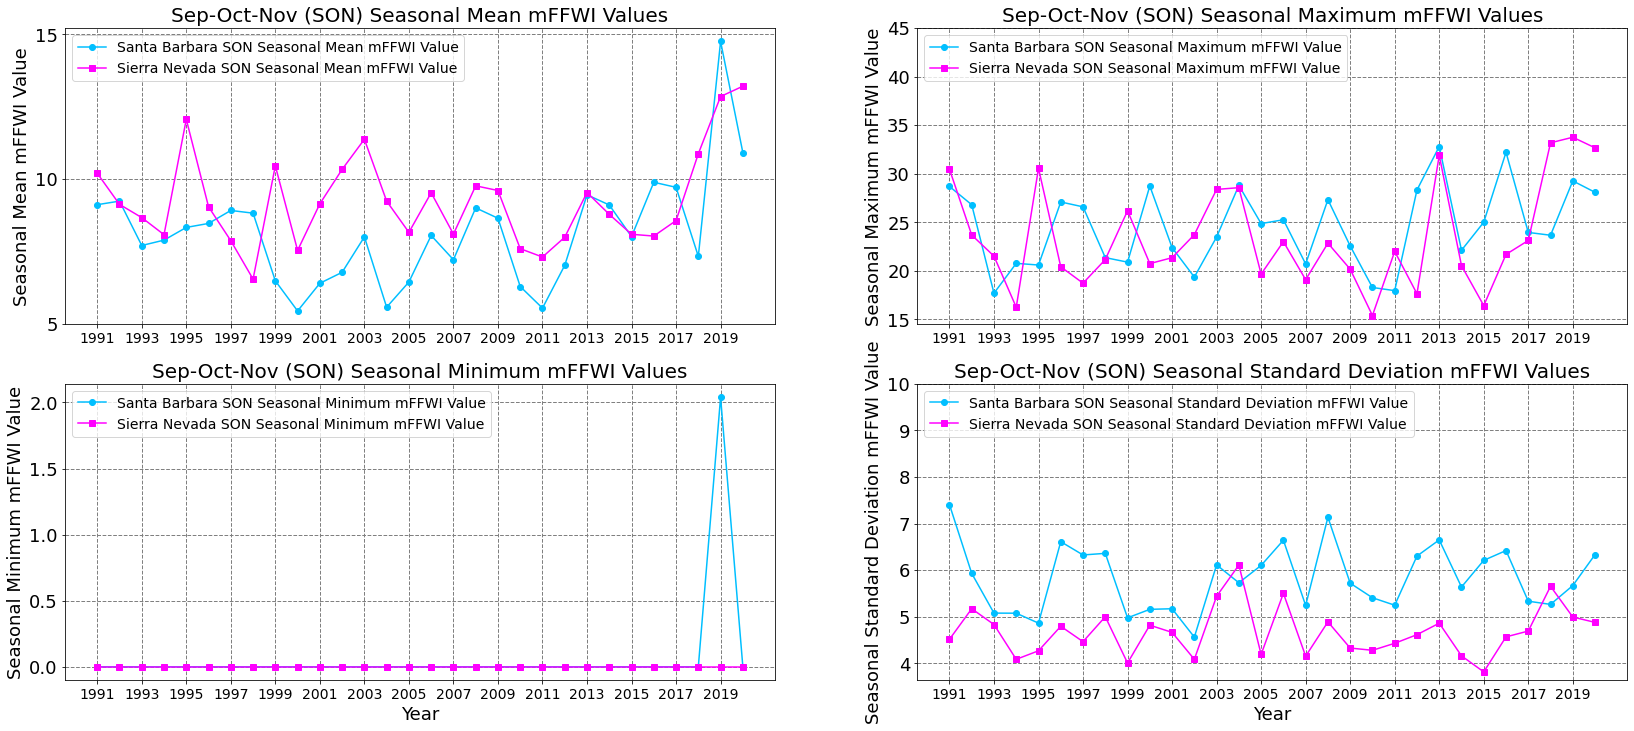

In [21]:
#----------------------------------------------------------------------------------------------------------------------
#Plot Seasonal SON mFFWI statistics for Santa Barbarba and Sierra Nevada WRF gridpoints

#Create figure and axis for plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(28,12))

#Define x-axis variable
years = np.arange(1991,2021,1)
#----------------------------------------------------------------------------------------------------------------------
#Plot seasonal mFFWI mean
ax1.plot(years,sb_model_mffwi_yearly_mean, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Mean mFFWI Value')
ax1.plot(years,sn_model_mffwi_yearly_mean, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Mean mFFWI Value')

#Plot seasonal mFFWI maximum values
ax2.plot(years,sb_model_mffwi_yearly_max, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Maximum mFFWI Value')
ax2.plot(years,sn_model_mffwi_yearly_max, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Maximum mFFWI Value')

#Plot seasonal mFFWI minimum values
ax3.plot(years,sb_model_mffwi_yearly_min, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Minimum mFFWI Value')
ax3.plot(years,sn_model_mffwi_yearly_min, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Minimum mFFWI Value')

#Plot seasonal mFFWI standard deviation values
ax4.plot(years,sb_model_mffwi_yearly_std, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Standard Deviation mFFWI Value')
ax4.plot(years,sn_model_mffwi_yearly_std, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Standard Deviation mFFWI Value')
#----------------------------------------------------------------------------------------------------------------------
#Add legend
ax1.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper left', fontsize=14)
ax3.legend(loc='upper left', fontsize=14)
ax4.legend(loc='upper left', fontsize=14)

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)
ax3.grid(color='grey', linestyle='--', linewidth=1)
ax4.grid(color='grey', linestyle='--', linewidth=1)

#Customize axes labels and styles
ax1.set_title('Sep-Oct-Nov (SON) Seasonal Mean mFFWI Values', fontsize=20)
ax2.set_title('Sep-Oct-Nov (SON) Seasonal Maximum mFFWI Values', fontsize=20)
ax3.set_title('Sep-Oct-Nov (SON) Seasonal Minimum mFFWI Values', fontsize=20)
ax4.set_title('Sep-Oct-Nov (SON) Seasonal Standard Deviation mFFWI Values', fontsize=20)

ax3.set_xlabel('Year', fontsize=18)
ax4.set_xlabel('Year', fontsize=18)

ax1.set_ylabel('Seasonal Mean mFFWI Value', fontsize=18)
ax2.set_ylabel('Seasonal Maximum mFFWI Value', fontsize=18)
ax3.set_ylabel('Seasonal Minimum mFFWI Value', fontsize=18)
ax4.set_ylabel('Seasonal Standard Deviation mFFWI Value', fontsize=18)

ax1.set_xticks(years[::2])
ax2.set_xticks(years[::2])
ax3.set_xticks(years[::2])
ax4.set_xticks(years[::2])

ax1.set_yticks(np.arange(5,20,5))
ax2.set_yticks(np.arange(15,50,5))
ax3.set_yticks(np.arange(0,2.5,0.5))
ax4.set_yticks(np.arange(4,11,1))

ax1.set_xticklabels(years[::2], fontsize=14)
ax2.set_xticklabels(years[::2], fontsize=14)
ax3.set_xticklabels(years[::2], fontsize=14)
ax4.set_xticklabels(years[::2], fontsize=14)

ax1.set_yticklabels(np.arange(5,20,5), fontsize=18)
ax2.set_yticklabels(np.arange(15,50,5), fontsize=18)
ax3.set_yticklabels(np.arange(0,2.5,0.5), fontsize=18)
ax4.set_yticklabels(np.arange(4,11,1), fontsize=18)

#Show plot
plt.show()
#----------------------------------------------------------------------------------------------------------------------b

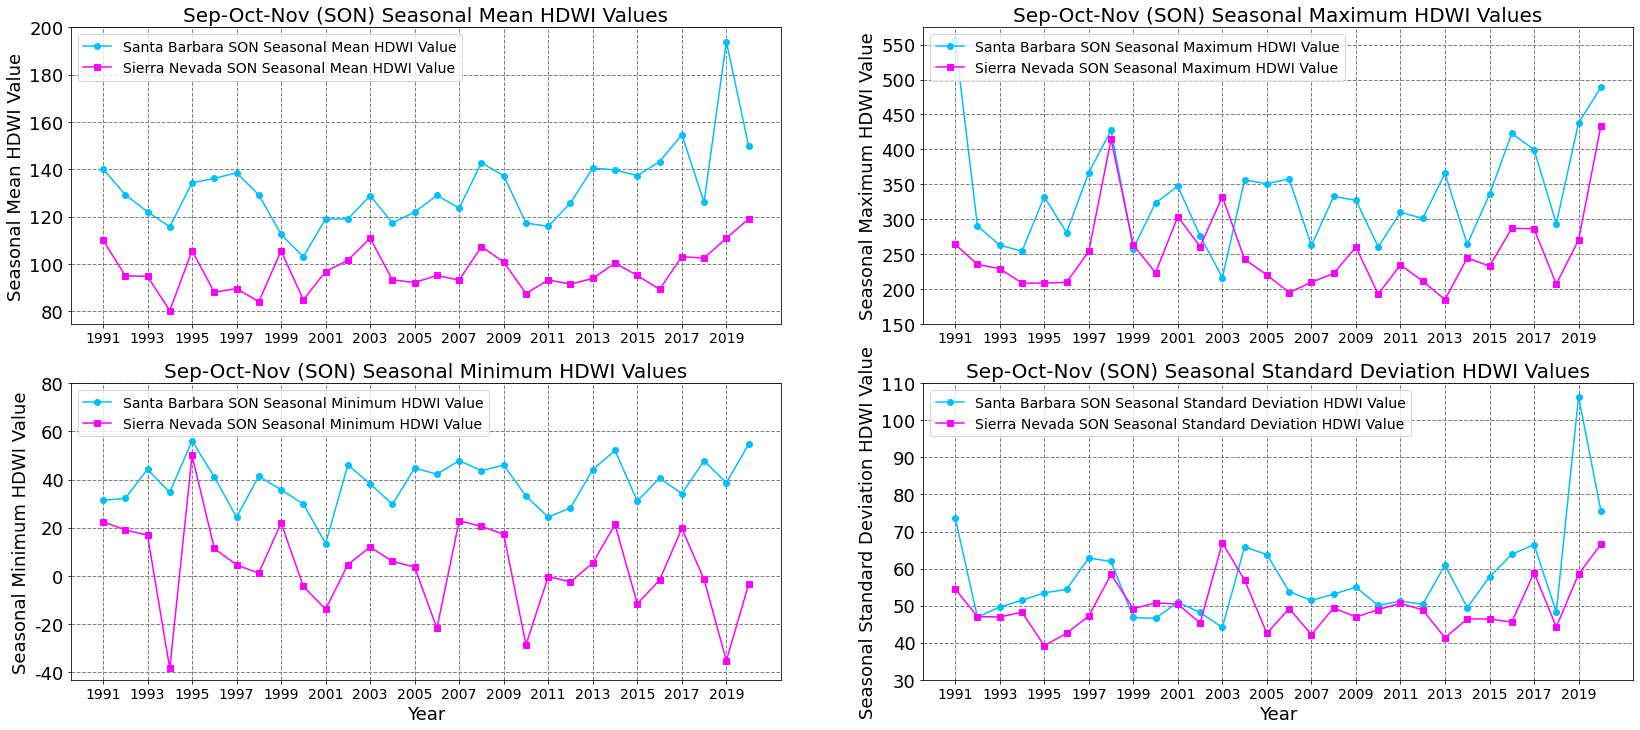

In [22]:
#----------------------------------------------------------------------------------------------------------------------
#Plot Seasonal SON HDWI statistics for Santa Barbarba and Sierra Nevada WRF gridpoints

#Create figure and axis for plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(28,12))

#Define x-axis variable
years = np.arange(1991,2021,1)
#----------------------------------------------------------------------------------------------------------------------
#Plot seasonal HDWI mean
ax1.plot(years,sb_model_hdwi_yearly_mean, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Mean HDWI Value')
ax1.plot(years,sn_model_hdwi_yearly_mean, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Mean HDWI Value')

#Plot seasonal HDWI maximum values
ax2.plot(years,sb_model_hdwi_yearly_max, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Maximum HDWI Value')
ax2.plot(years,sn_model_hdwi_yearly_max, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Maximum HDWI Value')

#Plot seasonal HDWI minimum values
ax3.plot(years,sb_model_hdwi_yearly_min, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Minimum HDWI Value')
ax3.plot(years,sn_model_hdwi_yearly_min, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Minimum HDWI Value')

#Plot seasonal HDWI standard deviation values
ax4.plot(years,sb_model_hdwi_yearly_std, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Standard Deviation HDWI Value')
ax4.plot(years,sn_model_hdwi_yearly_std, marker='s', color='magenta', label='Sierra Nevada SON Seasonal Standard Deviation HDWI Value')
#----------------------------------------------------------------------------------------------------------------------
#Add legend
ax1.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper left', fontsize=14)
ax3.legend(loc='upper left', fontsize=14)
ax4.legend(loc='upper left', fontsize=14)

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)
ax3.grid(color='grey', linestyle='--', linewidth=1)
ax4.grid(color='grey', linestyle='--', linewidth=1)

#Customize axes labels and styles
ax1.set_title('Sep-Oct-Nov (SON) Seasonal Mean HDWI Values', fontsize=20)
ax2.set_title('Sep-Oct-Nov (SON) Seasonal Maximum HDWI Values', fontsize=20)
ax3.set_title('Sep-Oct-Nov (SON) Seasonal Minimum HDWI Values', fontsize=20)
ax4.set_title('Sep-Oct-Nov (SON) Seasonal Standard Deviation HDWI Values', fontsize=20)

ax3.set_xlabel('Year', fontsize=18)
ax4.set_xlabel('Year', fontsize=18)

ax1.set_ylabel('Seasonal Mean HDWI Value', fontsize=18)
ax2.set_ylabel('Seasonal Maximum HDWI Value', fontsize=18)
ax3.set_ylabel('Seasonal Minimum HDWI Value', fontsize=18)
ax4.set_ylabel('Seasonal Standard Deviation HDWI Value', fontsize=18)

ax1.set_xticks(years[::2])
ax2.set_xticks(years[::2])
ax3.set_xticks(years[::2])
ax4.set_xticks(years[::2])

ax1.set_yticks(np.arange(80,220,20))
ax2.set_yticks(np.arange(150,600,50))
ax3.set_yticks(np.arange(-40,100,20))
ax4.set_yticks(np.arange(30,120,10))

ax1.set_xticklabels(years[::2], fontsize=14)
ax2.set_xticklabels(years[::2], fontsize=14)
ax3.set_xticklabels(years[::2], fontsize=14)
ax4.set_xticklabels(years[::2], fontsize=14)

ax1.set_yticklabels(np.arange(80,220,20), fontsize=18)
ax2.set_yticklabels(np.arange(150,600,50), fontsize=18)
ax3.set_yticklabels(np.arange(-40,100,20), fontsize=18)
ax4.set_yticklabels(np.arange(30,120,10), fontsize=18)

#Show plot
plt.show()
#----------------------------------------------------------------------------------------------------------------------

**Question 7C: Design criteria to identify weak, moderate, and very high fire weather potential days**

*The following cell performs the following task:*

- Creates a multipanel box and whisker plot for the daily FFWI and HDWI, which will be used as a way to identify weak, moderate, and very high fire weather potential days for both the Santa Barbara and Sierra Nevada WRF gridpoints.
---------------------------------------------------------------------------------------------------------------
- The percentile breakdowns apply to both the FFWI and HDWI, and are as follows: 

- Weak Fire Weather Potential  = When both the FFWI and HDWI are less than the 25th percentile (i.e. the bottom of the box on the box plot) | Moderate Fire Weather Potential  = When the FFWI and HDWI are both between the 25th and 75th percentile (i.e. the daily value falls within the box of the boxplot) | Extreme Fire Weather Potential = When both the FFWI and HDWI are both above the 75th percentile (i.e. the top of the box on the box plot)

- Note: These breakdowns were user selected and are not based on any previous theory or literature. They simply serve as one simple method to try to characterize various levels fire weather potential using daily FFWI and HDWI values. Also, outliers on the plot are defined as values that fall above the range created by adding the third quartile with 1.5 times the inter-quartile range or that fall below  the range created by subtracting the first quartile from the result of  1.5 times the inter-quartile range.
---------------------------------------------------------------------------------------------------------------
**Discussion of Box and Whisker Plot Results**
- Santa Barbara WRF gridpoint results: Weak fire weather potential days  are characterized as days where the FFWI is below ~5 and the HDWI is below ~100. Moderate fire weather potential days are characterized as days where the FFWI is between ~5 and ~12, and where the HDWI is between ~100 and ~150. Extreme fire weather potential days are characterized as days where the FFWI is above ~12, and where the HDWI is above ~150.

- Sierra Nevada WRF gridpoint results: Weak fire weather potential days  are characterized as days where the FFWI is below ~10 and the HDWI is below ~50. Moderate fire weather potential days are characterized as days where the FFWI is between ~10 and ~12, and where the HDWI is between ~80 and ~120. Extreme fire weather potential days are characterized as days where the FFWI is above ~14, and where the HDWI is above ~150.

- Additional Comments: The Sierra Nevada WRF gridpoint has a larger median daily FFWI value, but a smaller median daily HDWI value when compared to the Santa Barbara WRF gridpoint. Although both locations feature rather similar daily FFWI and HDWI values that fall within the 25th to 75th percentiles, they do differ for daily FFWI and HDWI values that fall outside of this range (which are considered to be weak and extreme fire weather potential days). This may reflect the importance in using various indexes/metrics to assess the fire weather potential for any one location, since one index may label a location with one category of fire weather potential while another index may label the same location in another fire weather potential category.

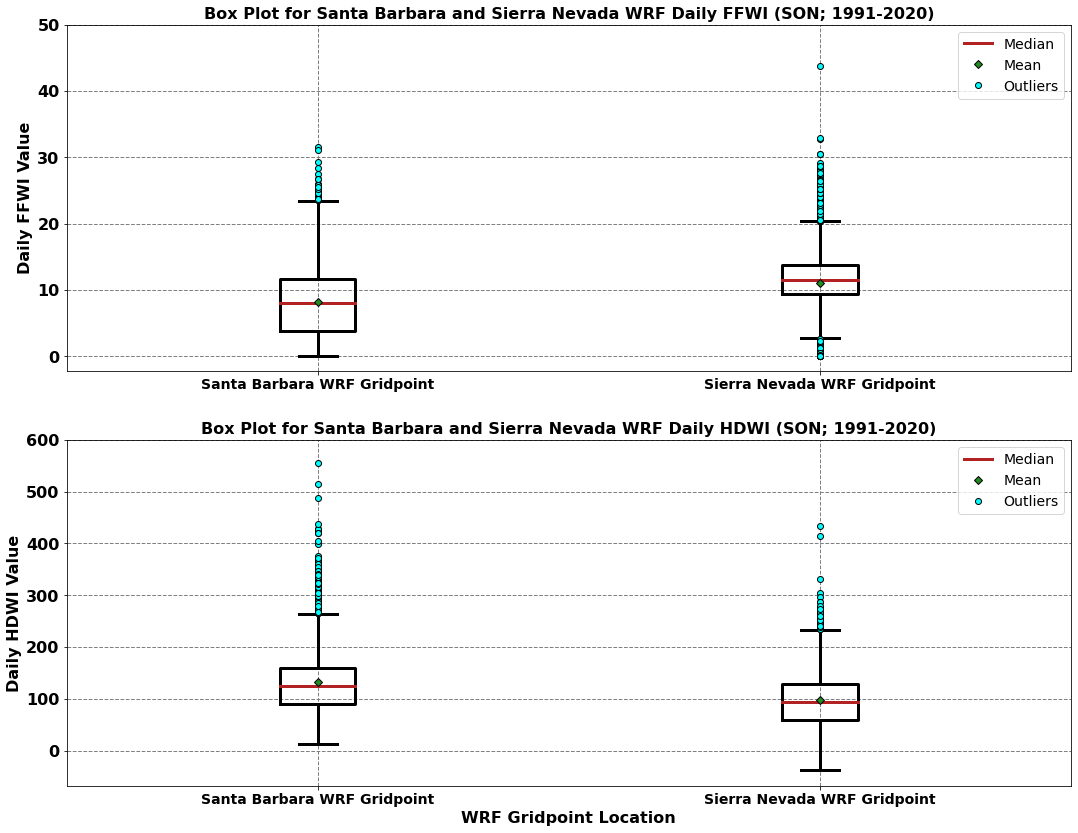

In [23]:
#----------------------------------------------------------------------------------------------------------------------
#Create figure and axis for plotting box and whisker plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

#Set some cool style to our box plot
#Pretty much all of these styles were taken from: https://matplotlib.org/3.1.0/gallery/statistics/boxplot.html
boxprops     = dict(linestyle='-', linewidth=3, color='black')
whiskerprops = dict(linestyle='-', linewidth=3, color='black')
capprops     = dict(linestyle='-', linewidth=3, color='black')
medianprops  = dict(linestyle='-', linewidth=3, color='firebrick')
meanprops    = dict(marker='D', markerfacecolor='forestgreen', markeredgecolor='black', markersize=6)
flierprops   = dict(marker='o', markerfacecolor='cyan', markeredgecolor='black', markersize=6)

#Make box plot and label all axes
boxplot_sb_and_sn_ffwi = ax1.boxplot([sb_model_gridpoint['Daily_FFWI'], sn_model_gridpoint['Daily_FFWI']], showmeans=True, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, meanprops=meanprops, flierprops=flierprops)
boxplot_sb_and_sn_hdwi = ax2.boxplot([sb_model_gridpoint['Daily_HDWI'], sn_model_gridpoint['Daily_HDWI']], showmeans=True, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, meanprops=meanprops, flierprops=flierprops)

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)

#Customize x and y axes
ax1.set_xticklabels(labels=['Santa Barbara WRF Gridpoint', 'Sierra Nevada WRF Gridpoint'], fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax2.set_xticklabels(labels=['Santa Barbara WRF Gridpoint', 'Sierra Nevada WRF Gridpoint'], fontdict={'fontsize': 14, 'fontweight': 'bold'})

ax2.set_xlabel('WRF Gridpoint Location', fontdict={'fontsize': 16, 'fontweight': 'bold'})

ax1.set_yticks(np.arange(0,60,10))
ax2.set_yticks(np.arange(0,700,100))

ax1.set_yticklabels(np.arange(0,60,10), fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax2.set_yticklabels(np.arange(0,700,100), fontdict={'fontsize': 16, 'fontweight': 'bold'})

ax1.set_ylabel('Daily FFWI Value', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax2.set_ylabel('Daily HDWI Value', fontdict={'fontsize': 16, 'fontweight': 'bold'})

ax1.set_title('Box Plot for Santa Barbara and Sierra Nevada WRF Daily FFWI (SON; 1991-2020)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax2.set_title('Box Plot for Santa Barbara and Sierra Nevada WRF Daily HDWI (SON; 1991-2020)', fontdict={'fontsize': 16, 'fontweight': 'bold'})

#Add legend to distinguish pieces of our boxplot
#This line came directly from: https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
ax1.legend([boxplot_sb_and_sn_ffwi['medians'][0], boxplot_sb_and_sn_ffwi['means'][0], boxplot_sb_and_sn_ffwi['fliers'][0]],['Median','Mean', 'Outliers'], fontsize=14)
ax2.legend([boxplot_sb_and_sn_hdwi['medians'][0], boxplot_sb_and_sn_hdwi['means'][0], boxplot_sb_and_sn_hdwi['fliers'][0]],['Median','Mean', 'Outliers'], fontsize=14)

#Show plot
plt.show()
#----------------------------------------------------------------------------------------------------------------------

**Question 7D: Calculate the linear trends in the FFWI, mFFWI, and HDWI seasonal means for both the Santa Barbara and Sierra Nevada gridpoints. In addition, estimate the statistical significance of the trends.**

*The following 3 cells perform the following tasks:*

- Calculates and plots the seasonal FFWI, mFFWI, and HDWI linear trends on top of the seasonal values

- Assesses if the linear trends are statistically significant using the using the Mann-Kendall significance test (from the pymannkendall package).

**Discussion on Linear Trends in Seasonal Mean FFWI, mFFWI, and HDWI Values**

- **FFWI Linear Trends:** Using the "polyfit" function from the numpy package we show that the Santa Barbara and Sierra Nevada WRF gridpoints demonstrate a potential positive linear trend with similar slope values, indicating that over time seasonal mean FFWI values have increased slightly. Using the Original Mann-Kendall test ("mk.original_test") function from the pymannkendall package, we find that both the Santa Barbara seasonal mean FFWI values and the Sierra Nevada seasonal mean FFWI values do NOT exhibit any statistically significant trends at the 0.05 significance level.

- **mFFWI Linear Trends:** Using the "polyfit" function from the numpy package we show that the Santa Barbara and Sierra Nevada WRF gridpoints demonstrate a potential positive linear trend with similar slope values, indicating that over time seasonal mean mFFWI values have increased slightly. Using the Original Mann-Kendall test ("mk.original_test") function from the pymannkendall package, we find that both the Santa Barbara seasonal mean mFFWI values and the Sierra Nevada seasonal mean mFFWI values do NOT exhibit any statistically significant trends at the 0.05 significance level.

- **HDWI Linear Trends:** Using the "polyfit" function from the numpy package we show that the Santa Barbara and Sierra Nevada WRF gridpoints demonstrate a potential positive linear trend with different slope values, indicating that over time seasonal mean HDWI values may be increasing slightly. Using the Original Mann-Kendall test ("mk.original_test") function from the pymannkendall package, we find that the Santa Barbara positive linear trend in the seasonal mean HDWI values is statistically significant at the 0.05 significance level, while the positive linear trend in the Sierra Nevada seasonal mean HDWI values is NOT  statistically significant at the 0.05 significance level.

Mann_Kendall_Test(trend='no trend', h=False, p=0.2844114676220473, z=1.0704618602100946, Tau=0.14022988505747128, s=61.0, var_s=3141.6666666666665, slope=0.03603040702924157, intercept=7.897190109496093)
Mann_Kendall_Test(trend='no trend', h=False, p=0.5441196833389506, z=0.6065950541190537, Tau=0.08045977011494253, s=35.0, var_s=3141.6666666666665, slope=0.008274857416277944, intercept=10.711839222243082)


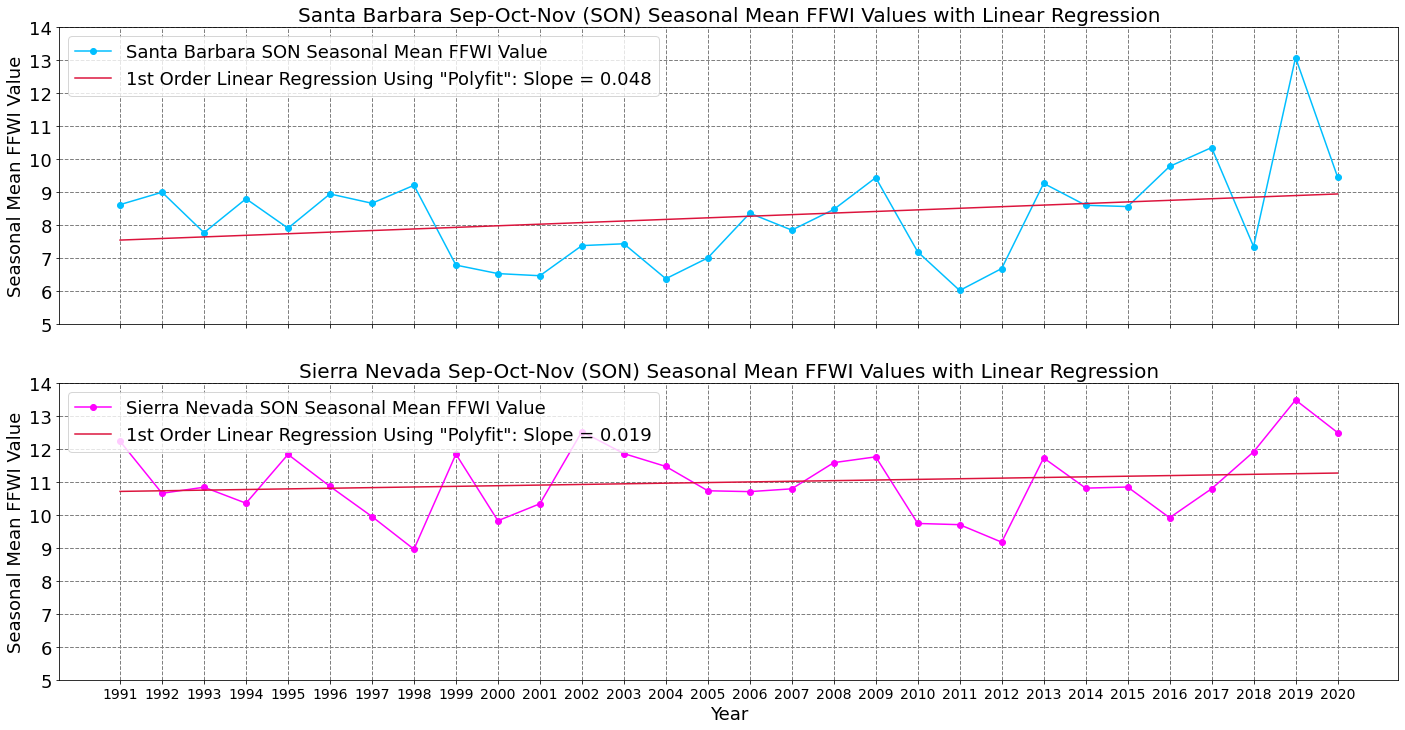

In [24]:
#----------------------------------------------------------------------------------------------------------------------
#Define x-variable to be used in the polyfit function
#We are workin with 30 years of seasonal FFWI values, so the x-axis will run from 0 to 29
x_variable_for_polyfit = np.arange(0, 30, 1)
#----------------------------------------------------------------------------------------------------------------------
#Define polyfit function for first order approximation
sb_linear_regression_ffwi_yearly = np.polyfit(x_variable_for_polyfit, sb_model_ffwi_yearly_mean, 1)
sn_linear_regression_ffwi_yearly = np.polyfit(x_variable_for_polyfit, sn_model_ffwi_yearly_mean, 1)

#Define polynomial using polyfit results
sb_first_order_polynomial_ffwi_yearly = np.poly1d(sb_linear_regression_ffwi_yearly)
sn_first_order_polynomial_ffwi_yearly = np.poly1d(sn_linear_regression_ffwi_yearly)
#----------------------------------------------------------------------------------------------------------------------
#Now we will use the pymankendall package to estimate the significance of the trend we found by passing the seasonal mean KBDI values
sb_model_mann_kendall_ffwi_yearly_mean = mk.original_test(sb_model_ffwi_yearly_mean)
sn_model_mann_kendall_ffwi_yearly_mean = mk.original_test(sn_model_ffwi_yearly_mean)

#If the user wants, they may print out the output of the Mann-Kendall trend test using the lines below:
print(sb_model_mann_kendall_ffwi_yearly_mean)
print(sn_model_mann_kendall_ffwi_yearly_mean)

#It appears that both trends are not statistically significant at the 0.05 significance level (default level for "mk.original_test" function)
#----------------------------------------------------------------------------------------------------------------------
#Now plot the seasonal mean FFWI gridpoint data, as well as the linear regression line

#Create a figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(24,12))

#Define x-axis variable
years = np.arange(1991,2021,1)
#----------------------------------------------------------------------------------------------------------------------
#Plot seasonal mean FFWI data for Santa Barbara, as well as the first order polynomial function we got from the 'polyfit' numpy function
ax1.plot(x_variable_for_polyfit, sb_model_ffwi_yearly_mean, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Mean FFWI Value')
ax1.plot(x_variable_for_polyfit, sb_first_order_polynomial_ffwi_yearly(x_variable_for_polyfit), color='crimson', label='1st Order Linear Regression Using "Polyfit": Slope = 0.048')

#Plot seasonal mean FFWI data for Sierra Nevada, as well as the first order polynomial function we got from the 'polyfit' numpy function
ax2.plot(x_variable_for_polyfit, sn_model_ffwi_yearly_mean, marker='o', color='magenta', label='Sierra Nevada SON Seasonal Mean FFWI Value')
ax2.plot(x_variable_for_polyfit, sn_first_order_polynomial_ffwi_yearly(x_variable_for_polyfit), color='crimson', label='1st Order Linear Regression Using "Polyfit": Slope = 0.019')
#----------------------------------------------------------------------------------------------------------------------
#Add legend
ax1.legend(loc='upper left', fontsize=18)
ax2.legend(loc='upper left', fontsize=18)

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)

#Customize axes labels and styles
ax1.set_title('Santa Barbara Sep-Oct-Nov (SON) Seasonal Mean FFWI Values with Linear Regression', fontsize=20)
ax2.set_title('Sierra Nevada Sep-Oct-Nov (SON) Seasonal Mean FFWI Values with Linear Regression', fontsize=20)

ax2.set_xlabel('Year', fontsize=18)

ax1.set_ylabel('Seasonal Mean FFWI Value', fontsize=18)
ax2.set_ylabel('Seasonal Mean FFWI Value', fontsize=18)

ax1.set_xticks(x_variable_for_polyfit)
ax2.set_xticks(x_variable_for_polyfit)

ax1.set_xticklabels([], fontsize=14)
ax2.set_xticklabels(years, fontsize=14)

ax1.set_yticks(np.arange(5,15,1))
ax2.set_yticks(np.arange(5,15,1))

ax1.set_yticklabels(np.arange(5,15,1), fontsize=18)
ax2.set_yticklabels(np.arange(5,15,1), fontsize=18)

#Show Plot
plt.show()
#----------------------------------------------------------------------------------------------------------------------

Mann_Kendall_Test(trend='no trend', h=False, p=0.1989481007752456, z=1.2845542322521135, Tau=0.167816091954023, s=73.0, var_s=3141.6666666666665, slope=0.05032360307354562, intercept=7.307525828544982)
Mann_Kendall_Test(trend='no trend', h=False, p=0.6685166224807093, z=0.4281847440840379, Tau=0.05747126436781609, s=25.0, var_s=3141.6666666666665, slope=0.0123355901016405, intercept=8.909503499830262)


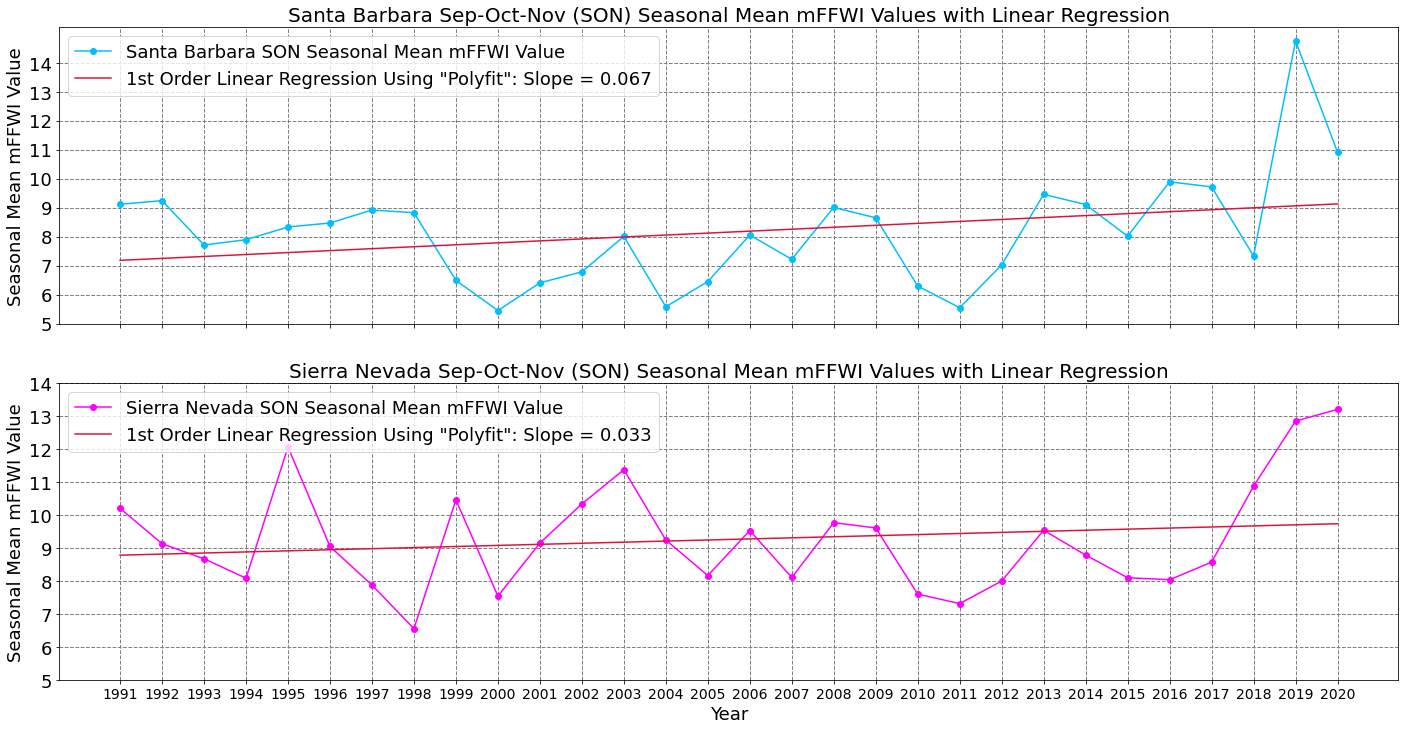

In [25]:
#----------------------------------------------------------------------------------------------------------------------
#Define x-variable to be used in the polyfit function
#We are workin with 30 years of seasonal mFFWI values, so the x-axis will run from 0 to 29
x_variable_for_polyfit = np.arange(0, 30, 1)
#----------------------------------------------------------------------------------------------------------------------
#Define polyfit function for first order approximation
sb_linear_regression_mffwi_yearly = np.polyfit(x_variable_for_polyfit, sb_model_mffwi_yearly_mean, 1)
sn_linear_regression_mffwi_yearly = np.polyfit(x_variable_for_polyfit, sn_model_mffwi_yearly_mean, 1)

#Define polynomial using polyfit results
sb_first_order_polynomial_mffwi_yearly = np.poly1d(sb_linear_regression_mffwi_yearly)
sn_first_order_polynomial_mffwi_yearly = np.poly1d(sn_linear_regression_mffwi_yearly)
#----------------------------------------------------------------------------------------------------------------------
#Now we will use the pymankendall package to estimate the significance of the trend we found by passing the seasonal mean KBDI values
sb_model_mann_kendall_mffwi_yearly_mean = mk.original_test(sb_model_mffwi_yearly_mean)
sn_model_mann_kendall_mffwi_yearly_mean = mk.original_test(sn_model_mffwi_yearly_mean)

#If the user wants, they may print out the output of the Mann-Kendall trend test using the lines below:
print(sb_model_mann_kendall_mffwi_yearly_mean)
print(sn_model_mann_kendall_mffwi_yearly_mean)

#It appears that both trends are not statistically significant at the 0.05 significance level (default level for "mk.original_test" function)
#----------------------------------------------------------------------------------------------------------------------
#Now plot the seasonal mean mFFWI gridpoint data, as well as the linear regression line

#Create a figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(24,12))

#Define x-axis variable
years = np.arange(1991,2021,1)
#----------------------------------------------------------------------------------------------------------------------
#Plot seasonal mean mFFWI data for Santa Barbara, as well as the first order polynomial function we got from the 'polyfit' numpy function
ax1.plot(x_variable_for_polyfit, sb_model_mffwi_yearly_mean, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Mean mFFWI Value')
ax1.plot(x_variable_for_polyfit, sb_first_order_polynomial_mffwi_yearly(x_variable_for_polyfit), color='crimson', label='1st Order Linear Regression Using "Polyfit": Slope = 0.067')

#Plot seasonal mean mFFWI data for Sierra Nevada, as well as the first order polynomial function we got from the 'polyfit' numpy function
ax2.plot(x_variable_for_polyfit, sn_model_mffwi_yearly_mean, marker='o', color='magenta', label='Sierra Nevada SON Seasonal Mean mFFWI Value')
ax2.plot(x_variable_for_polyfit, sn_first_order_polynomial_mffwi_yearly(x_variable_for_polyfit), color='crimson', label='1st Order Linear Regression Using "Polyfit": Slope = 0.033')
#----------------------------------------------------------------------------------------------------------------------
#Add legend
ax1.legend(loc='upper left', fontsize=18)
ax2.legend(loc='upper left', fontsize=18)

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)

#Customize axes labels and styles
ax1.set_title('Santa Barbara Sep-Oct-Nov (SON) Seasonal Mean mFFWI Values with Linear Regression', fontsize=20)
ax2.set_title('Sierra Nevada Sep-Oct-Nov (SON) Seasonal Mean mFFWI Values with Linear Regression', fontsize=20)

ax2.set_xlabel('Year', fontsize=18)

ax1.set_ylabel('Seasonal Mean mFFWI Value', fontsize=18)
ax2.set_ylabel('Seasonal Mean mFFWI Value', fontsize=18)

ax1.set_xticks(x_variable_for_polyfit)
ax2.set_xticks(x_variable_for_polyfit)

ax1.set_xticklabels([], fontsize=14)
ax2.set_xticklabels(years, fontsize=14)

ax1.set_yticks(np.arange(5,15,1))
ax2.set_yticks(np.arange(5,15,1))

ax1.set_yticklabels(np.arange(5,15,1), fontsize=18)
ax2.set_yticklabels(np.arange(5,15,1), fontsize=18)

#Show Plot
plt.show()
#----------------------------------------------------------------------------------------------------------------------

Mann_Kendall_Test(trend='increasing', h=True, p=0.02950999336955995, z=2.1766057824271927, Tau=0.2827586206896552, s=123.0, var_s=3141.6666666666665, slope=0.6885685895437319, intercept=119.04307944266031)
Mann_Kendall_Test(trend='no trend', h=False, p=0.17512514633807807, z=1.35591835626612, Tau=0.17701149425287357, s=77.0, var_s=3141.6666666666665, slope=0.3017603632874426, intercept=90.62935222601516)


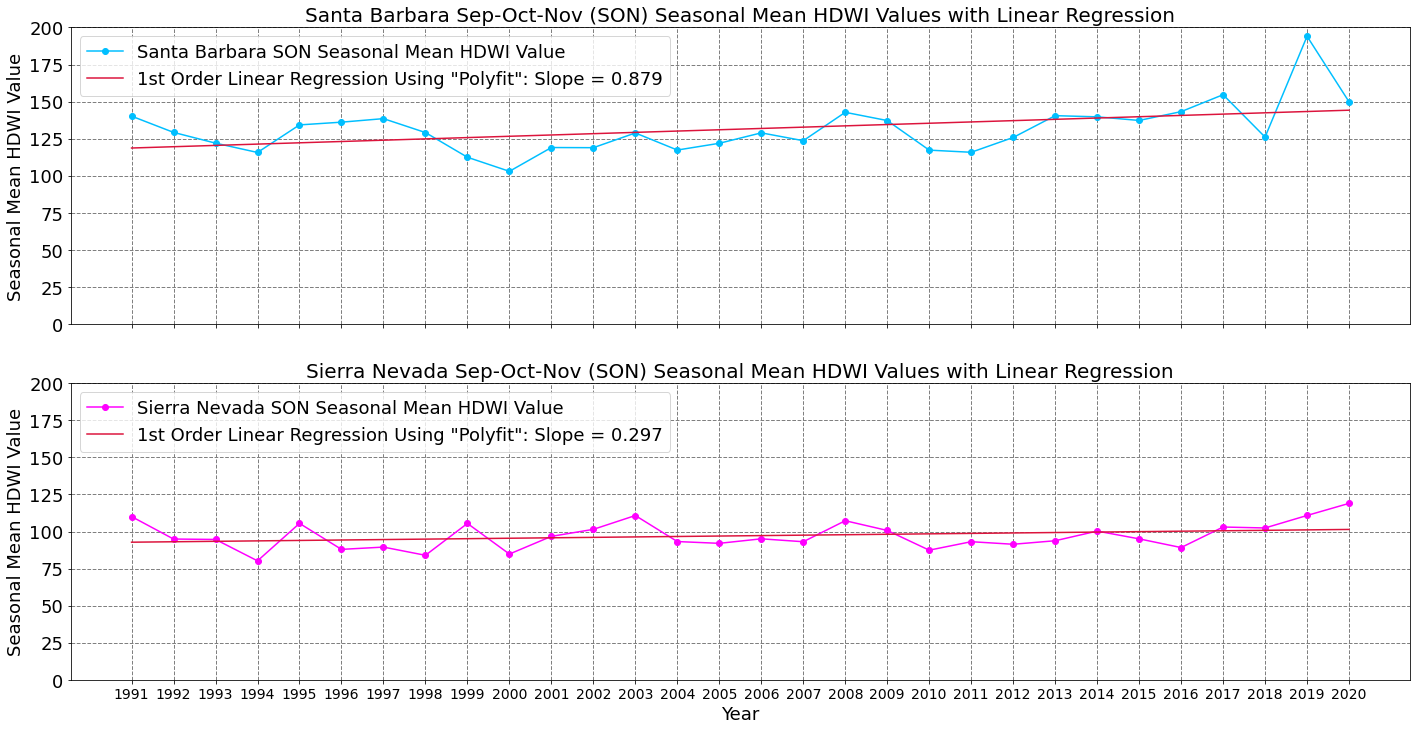

In [27]:
#----------------------------------------------------------------------------------------------------------------------
#Define x-variable to be used in the polyfit function
#We are workin with 30 years of seasonal HDWI values, so the x-axis will run from 0 to 29
x_variable_for_polyfit = np.arange(0, 30, 1)
#----------------------------------------------------------------------------------------------------------------------
#Define polyfit function for first order approximation
sb_linear_regression_hdwi_yearly = np.polyfit(x_variable_for_polyfit, sb_model_hdwi_yearly_mean, 1)
sn_linear_regression_hdwi_yearly = np.polyfit(x_variable_for_polyfit, sn_model_hdwi_yearly_mean, 1)

#Define polynomial using polyfit results
sb_first_order_polynomial_hdwi_yearly = np.poly1d(sb_linear_regression_hdwi_yearly)
sn_first_order_polynomial_hdwi_yearly = np.poly1d(sn_linear_regression_hdwi_yearly)
#----------------------------------------------------------------------------------------------------------------------
#Now we will use the pymankendall package to estimate the significance of the trend we found by passing the seasonal mean KBDI values
sb_model_mann_kendall_hdwi_yearly_mean = mk.original_test(sb_model_hdwi_yearly_mean)
sn_model_mann_kendall_hdwi_yearly_mean = mk.original_test(sn_model_hdwi_yearly_mean)

#If the user wants, they may print out the output of the Mann-Kendall trend test using the lines below:
print(sb_model_mann_kendall_hdwi_yearly_mean)
print(sn_model_mann_kendall_hdwi_yearly_mean)

#It appears that the positive linear trend for the Sierra Nevada WRF is  statistically significant at the 0.05 significance level (default level for "mk.original_test" function)
#It appears that the positive linear trend for the Sierra Nevada WRF is not statistically significant at the 0.05 significance level (default level for "mk.original_test" function)
#----------------------------------------------------------------------------------------------------------------------
#Now plot the seasonal mean HDWI gridpoint data, as well as the linear regression line

#Create a figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(24,12))

#Define x-axis variable
years = np.arange(1991,2021,1)
#----------------------------------------------------------------------------------------------------------------------
#Plot seasonal mean HDWI data for Santa Barbara, as well as the first order polynomial function we got from the 'polyfit' numpy function
ax1.plot(x_variable_for_polyfit, sb_model_hdwi_yearly_mean, marker='o', color='deepskyblue', label='Santa Barbara SON Seasonal Mean HDWI Value')
ax1.plot(x_variable_for_polyfit, sb_first_order_polynomial_hdwi_yearly(x_variable_for_polyfit), color='crimson', label='1st Order Linear Regression Using "Polyfit": Slope = 0.879')

#Plot seasonal mean HDWI data for Sierra Nevada, as well as the first order polynomial function we got from the 'polyfit' numpy function
ax2.plot(x_variable_for_polyfit, sn_model_hdwi_yearly_mean, marker='o', color='magenta', label='Sierra Nevada SON Seasonal Mean HDWI Value')
ax2.plot(x_variable_for_polyfit, sn_first_order_polynomial_hdwi_yearly(x_variable_for_polyfit), color='crimson', label='1st Order Linear Regression Using "Polyfit": Slope = 0.297')
#----------------------------------------------------------------------------------------------------------------------
#Add legend
ax1.legend(loc='upper left', fontsize=18)
ax2.legend(loc='upper left', fontsize=18)

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)

#Customize axes labels and styles
ax1.set_title('Santa Barbara Sep-Oct-Nov (SON) Seasonal Mean HDWI Values with Linear Regression', fontsize=20)
ax2.set_title('Sierra Nevada Sep-Oct-Nov (SON) Seasonal Mean HDWI Values with Linear Regression', fontsize=20)

ax2.set_xlabel('Year', fontsize=18)

ax1.set_ylabel('Seasonal Mean HDWI Value', fontsize=18)
ax2.set_ylabel('Seasonal Mean HDWI Value', fontsize=18)

ax1.set_xticks(x_variable_for_polyfit)
ax2.set_xticks(x_variable_for_polyfit)

ax1.set_xticklabels([], fontsize=14)
ax2.set_xticklabels(years, fontsize=14)

ax1.set_yticks(np.arange(0,225,25))
ax2.set_yticks(np.arange(0,225,25))

ax1.set_yticklabels(np.arange(0,225,25), fontsize=18)
ax2.set_yticklabels(np.arange(0,225,25), fontsize=18)

#Show Plot
plt.show()
#----------------------------------------------------------------------------------------------------------------------

**Question 8: Compute unlagged and lag correlations between the seasonal ENSO index in December-January-February (DJF) and the seasonal mean values of KBDI, FFWI, mFFWI, and HDWI for both the Santa Barbara and Sierra Nevada WRF gridpoints.**

*The following 4 cells perform the following tasks:*

- Computes unlagged  and lag correlations (i.e. computation of Pearson's correlation coefficient) between the seasonal ENSO index in December-January-February (DJF) and the seasonal mean values of KBDI, FFWI, mFFWI, and HDWI for both the Santa Barbara and Sierra Nevada WRF gridpoints.

**Discussion of ENSO unlagged and lagged correlations with seasonal KBDI, FFWI, mFFWI, and HDWI for the Santa Barbara and Sierra Nevada WRF gridpoints**

- **Unlagged Correlations:** It appears that there are no strong correlations between any of the computed seasonal mean indexes (KBDI, FFWI, mFFWI, and HDWI) and the DJF ENSO index from the same year, espcially for the Sierra Nevada WRF gridpoint. For the Santa Barbara WRF gridpoint the strongest correlation observed is between the FFWI and the DJF ENSO index with a Pearson Correlation Coefficient value of ~0.33, which is not particularly strong. From this unlagged correlation it appears that there is no relationship between the DJF ENSO index value and the seasonal mean value for KBDI, FFWI, mFFWI, and HDWI of the same year.

- **Lag-1 Correlation:** Correlation coefficient values for the Santa Barbara WRF gridpoint have all decreased by a large amount when computing a lag-1 correlation between seasonal KBDI, FFWI, mFFWI, and HDWI and the DJF ENSO index value. For the Sierra Nevada WRF gridpoint, we observe that correlation coefficient values have all shifted to positive values when computing a lag-1 correlation between seasonal KBDI, FFWI, mFFWI, and HDWI and the DJF ENSO index value. The Lag-1 Correlation Coefficient value between seasonal FFWI and the DJF ENSO index value, as well as the Lag-1 Correlation Coefficient value between seasonal FFWI and the DJF ENSO index values, did increase but the maximum coefficient value is still only around 0.18, indicating a weak relationship.

- **Final Thoughts:** It appears that ENSO is not well correlated with any of the indexes computed. Future work may look at computing the statistical significance of these correlations and computing additional time lags to see if any more meaningful relationships can be found.

In [28]:
#----------------------------------------------------------------------------------------------------------------------
#Define DJF ENSO index values starting with DJF in 1991 and going until DJF in 2020
#The ENSO index values are mean sea surface temperature values and are based on a threshold value of +- 0.5°C
djf_enso_index_values = [0.4, 1.7, 0.1, 0.1, 1.0, -0.9, -0.5, 2.2, -1.5, -1.7, -0.7, -0.1, 0.9, 0.4, 0.6, -0.9, 0.7, -1.6, -0.8, 1.5, -1.4, -0.9, -0.4, -0.4, 0.5, 2.5, -0.3, -0.9, 0.7, 0.5]
#----------------------------------------------------------------------------------------------------------------------
#Compute unlagged correlation between seasonal KBDI and DJF ENSO index values for both WRF gridpoints
#Correlation type: Pearson's Correlation Coefficient
sb_model_kbdi_yearly_mean_pearson_corr_djf_enso_index = np.corrcoef(sb_model_kbdi_yearly_mean, djf_enso_index_values)[1,0]
sn_model_kbdi_yearly_mean_pearson_corr_djf_enso_index = np.corrcoef(sn_model_kbdi_yearly_mean, djf_enso_index_values)[1,0]

#Compute unlagged correlation between seasonal FFWI and DJF ENSO index values for both WRF gridpoints
#Correlation type: Pearson's Correlation Coefficient
sb_model_ffwi_yearly_mean_pearson_corr_djf_enso_index = np.corrcoef(sb_model_ffwi_yearly_mean, djf_enso_index_values)[1,0]
sn_model_ffwi_yearly_mean_pearson_corr_djf_enso_index = np.corrcoef(sn_model_ffwi_yearly_mean, djf_enso_index_values)[1,0]

#Compute unlagged correlation between seasonal mFFWI and DJF ENSO index values for both WRF gridpoints
#Correlation type: Pearson's Correlation Coefficient
sb_model_mffwi_yearly_mean_pearson_corr_djf_enso_index = np.corrcoef(sb_model_mffwi_yearly_mean, djf_enso_index_values)[1,0]
sn_model_mffwi_yearly_mean_pearson_corr_djf_enso_index = np.corrcoef(sn_model_mffwi_yearly_mean, djf_enso_index_values)[1,0]

#Compute unlagged correlation between seasonal HDWI and DJF ENSO index values for both WRF gridpoints
#Correlation type: Pearson's Correlation Coefficient
sb_model_hdwi_yearly_mean_pearson_corr_djf_enso_index = np.corrcoef(sb_model_hdwi_yearly_mean, djf_enso_index_values)[1,0]
sn_model_hdwi_yearly_mean_pearson_corr_djf_enso_index = np.corrcoef(sn_model_hdwi_yearly_mean, djf_enso_index_values)[1,0]
#----------------------------------------------------------------------------------------------------------------------
#Compute lag-1 (ENSO index is shifted forward by 1) correlation between seasonal KBDI and DJF ENSO index values for both WRF gridpoints
#Correlation type: Pearson's Correlation Coefficient
sb_model_kbdi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1 = np.corrcoef(sb_model_kbdi_yearly_mean[1::], djf_enso_index_values[0:-1])[1,0]
sn_model_kbdi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1 = np.corrcoef(sn_model_kbdi_yearly_mean[1::], djf_enso_index_values[0:-1])[1,0]

#Compute lag-1 (ENSO index is shifted forward by 1)correlation between seasonal FFWI and DJF ENSO index values for both WRF gridpoints
#Correlation type: Pearson's Correlation Coefficient
sb_model_ffwi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1 = np.corrcoef(sb_model_ffwi_yearly_mean[1::], djf_enso_index_values[0:-1])[1,0]
sn_model_ffwi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1 = np.corrcoef(sn_model_ffwi_yearly_mean[1::], djf_enso_index_values[0:-1])[1,0]

#Compute lag-1 (ENSO index is shifted forward by 1) correlation between seasonal mFFWI and DJF ENSO index values for both WRF gridpoints
#Correlation type: Pearson's Correlation Coefficient
sb_model_mffwi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1 = np.corrcoef(sb_model_mffwi_yearly_mean[1::], djf_enso_index_values[0:-1])[1,0]
sn_model_mffwi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1 = np.corrcoef(sn_model_mffwi_yearly_mean[1::], djf_enso_index_values[0:-1])[1,0]

#Compute lag-1 (ENSO index is shifted forward by 1) correlation between seasonal HDWI and DJF ENSO index values for both WRF gridpoints
#Correlation type: Pearson's Correlation Coefficient
sb_model_hdwi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1 = np.corrcoef(sb_model_hdwi_yearly_mean[1::], djf_enso_index_values[0:-1])[1,0]
sn_model_hdwi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1 = np.corrcoef(sn_model_hdwi_yearly_mean[1::], djf_enso_index_values[0:-1])[1,0]
#----------------------------------------------------------------------------------------------------------------------

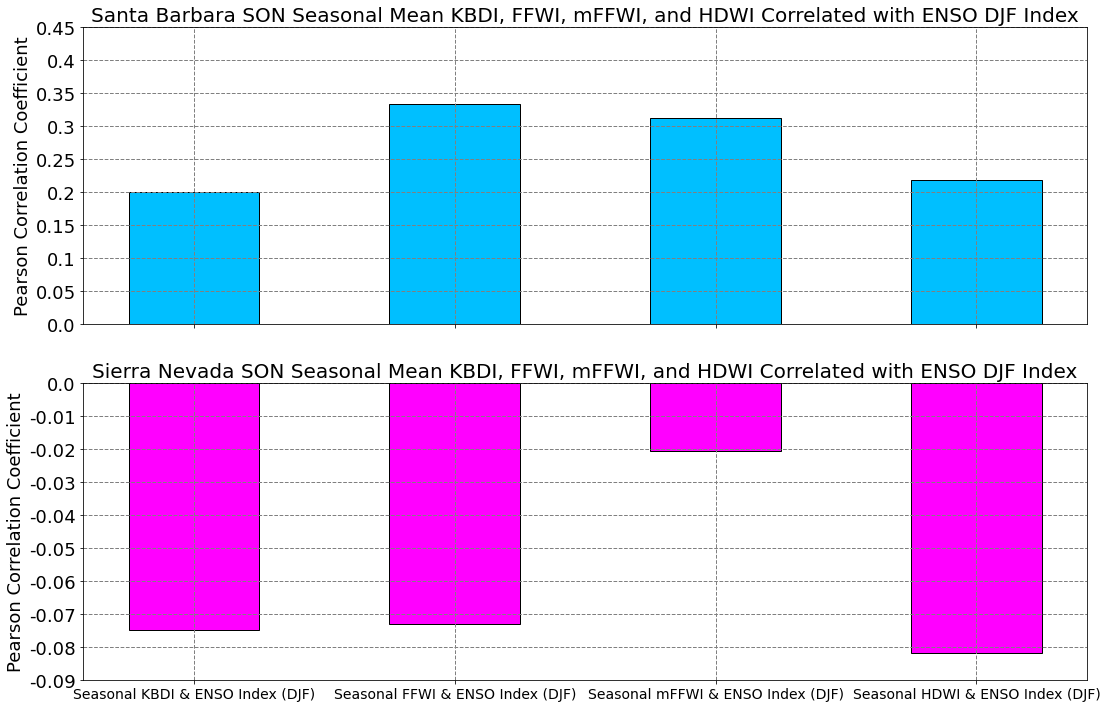

In [29]:
#----------------------------------------------------------------------------------------------------------------------
#Plot unlagged correlation between KBDI, FFWI, mFFWI, and HDWI seasonal means and ENSO DJF index
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,12))

#Define x-axis variable (labels for bar chart)
bar_labels = ['Seasonal KBDI & ENSO Index (DJF)', 'Seasonal FFWI & ENSO Index (DJF)', 'Seasonal mFFWI & ENSO Index (DJF)', 'Seasonal HDWI & ENSO Index (DJF)']

#Define y-axis variable (unlagged Pearson correlation coefficient values for each index)
sb_model_all_yearly_mean_pearson_corr_djf_enso_index = [sb_model_kbdi_yearly_mean_pearson_corr_djf_enso_index, sb_model_ffwi_yearly_mean_pearson_corr_djf_enso_index, sb_model_mffwi_yearly_mean_pearson_corr_djf_enso_index, sb_model_hdwi_yearly_mean_pearson_corr_djf_enso_index]
sn_model_all_yearly_mean_pearson_corr_djf_enso_index = [sn_model_kbdi_yearly_mean_pearson_corr_djf_enso_index, sn_model_ffwi_yearly_mean_pearson_corr_djf_enso_index, sn_model_mffwi_yearly_mean_pearson_corr_djf_enso_index, sn_model_hdwi_yearly_mean_pearson_corr_djf_enso_index]

#Plot bar chart
ax1.bar(bar_labels, sb_model_all_yearly_mean_pearson_corr_djf_enso_index, width=0.5, color='deepskyblue', edgecolor='black',)
ax2.bar(bar_labels, sn_model_all_yearly_mean_pearson_corr_djf_enso_index, width=0.5, color='magenta', edgecolor='black')

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)

#Customize axes labels and styles
ax1.set_title('Santa Barbara SON Seasonal Mean KBDI, FFWI, mFFWI, and HDWI Correlated with ENSO DJF Index', fontsize=20)
ax2.set_title('Sierra Nevada SON Seasonal Mean KBDI, FFWI, mFFWI, and HDWI Correlated with ENSO DJF Index', fontsize=20)

ax1.set_ylabel('Pearson Correlation Coefficient', fontsize=18)
ax2.set_ylabel('Pearson Correlation Coefficient', fontsize=18)

ax1.set_xticks(bar_labels)
ax2.set_xticks(bar_labels)

ax1.set_xticklabels([])
ax2.set_xticklabels(bar_labels, fontsize=14)

ax1.set_yticks(np.round(np.arange(0,0.5,0.05), 2))
ax2.set_yticks(np.arange(0,-0.1,-0.01))

ax1.set_yticklabels(np.round(np.arange(0,0.5,0.05), 2), fontsize=18)
ax2.set_yticklabels(np.arange(0,-0.1,-0.01), fontsize=18)

#Show Plot
plt.show()
#----------------------------------------------------------------------------------------------------------------------

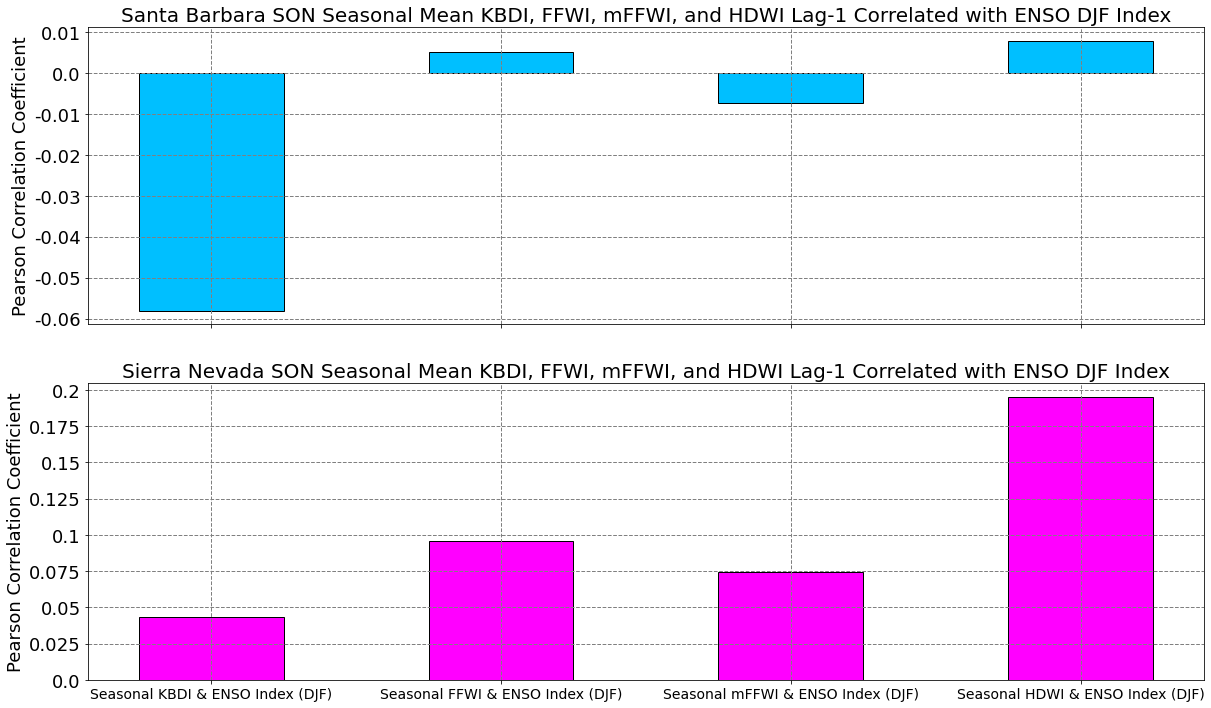

In [30]:
#----------------------------------------------------------------------------------------------------------------------
#Plot lag-1 correlation between KBDI, FFWI, mFFWI, and HDWI seasonal means and ENSO DJF index
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,12))

#Define x-axis variable (labels for bar chart)
bar_labels = ['Seasonal KBDI & ENSO Index (DJF)', 'Seasonal FFWI & ENSO Index (DJF)', 'Seasonal mFFWI & ENSO Index (DJF)', 'Seasonal HDWI & ENSO Index (DJF)']

#Define y-axis variable (unlagged Pearson correlation coefficient values for each index)
sb_model_all_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1 = [sb_model_kbdi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1, sb_model_ffwi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1, sb_model_mffwi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1, sb_model_hdwi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1]
sn_model_all_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1 = [sn_model_kbdi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1, sn_model_ffwi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1, sn_model_mffwi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1, sn_model_hdwi_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1]

#Plot bar chart
ax1.bar(bar_labels, sb_model_all_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1, width=0.5, color='deepskyblue', edgecolor='black',)
ax2.bar(bar_labels, sn_model_all_yearly_mean_pearson_corr_djf_enso_index_lag_minus_1, width=0.5, color='magenta', edgecolor='black')

#Add grid
ax1.grid(color='grey', linestyle='--', linewidth=1)
ax2.grid(color='grey', linestyle='--', linewidth=1)

#Customize axes labels and styles
ax1.set_title('Santa Barbara SON Seasonal Mean KBDI, FFWI, mFFWI, and HDWI Lag-1 Correlated with ENSO DJF Index', fontsize=20)
ax2.set_title('Sierra Nevada SON Seasonal Mean KBDI, FFWI, mFFWI, and HDWI Lag-1 Correlated with ENSO DJF Index', fontsize=20)

ax1.set_ylabel('Pearson Correlation Coefficient', fontsize=18)
ax2.set_ylabel('Pearson Correlation Coefficient', fontsize=18)

ax1.set_xticks(bar_labels)
ax2.set_xticks(bar_labels)

ax1.set_xticklabels([])
ax2.set_xticklabels(bar_labels, fontsize=14)

ax1.set_yticks(np.round(np.arange(-0.06,0.02,0.01), 2))
ax2.set_yticks(np.round(np.arange(0,0.225,0.025), 3))

ax1.set_yticklabels(np.round(np.arange(-0.06,0.02,0.01), 2), fontsize=18)
ax2.set_yticklabels(np.round(np.arange(0,0.225,0.025), 3), fontsize=18)

#Show Plot
plt.show()
#----------------------------------------------------------------------------------------------------------------------